In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import pearsonr

In [3]:
import utils_plot
import utils_config
from utils_plot import plot_barplot, plot_boxplot

In [4]:
import met_brewer

## Settings

In [5]:
TEXT_WIDTH = 6.7261  # in
DPI = 360

In [6]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

# Settings

In [7]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(20)

# Load data
## Raw data

In [8]:
known_epitopes = [
    'QYIKWPWYI',
    'NYNYLYRLF',
    'LTDEMIAQY',
    'YLQPRTFLL',
    'GILGFVFTL', 
    'SPRRARSVA',
    'CTELKLSDY',
    'AYAQKIFKI',
    'RLQSLQTYV',
    'NLVPMVATV',
    'YVLDHLIVV',
    'FPQSAPHGV',   
    'KCYGVSPTK',
    'TYGPVFMCL'
]

In [9]:
df_data = pd.read_csv('../tcr_benchmark/data/viral.csv', index_col=0)
df_data['In VDJdb'] = df_data['Epitope'].apply(lambda x: 'True' if x in known_epitopes else 'False')
df_data.head()

,CDR3_alpha,CDR3_beta,V_alpha,V_beta,J_alpha,J_beta,Epitope,clone_id,MHC,In VDJdb
0,CAVNAPTGTASKLTF,CASSMRSAVEQYF,TRAV8-1*01,TRBV19*01,TRAJ44*01,TRBJ2-7*01,GILGFVFTL,25.0,HLA-A*02:01,True
1,CAVEGSQGNLIF,CASSMRSAVEQYF,TRAV2*01,TRBV19*01,TRAJ42*01,TRBJ2-7*01,GILGFVFTL,27.0,HLA-A*02:01,True
2,CAGWPGSSNTGKLIF,CASSIRSLAEQYF,TRAV25*01,TRBV19*01,TRAJ37*01,TRBJ2-7*01,GILGFVFTL,34.0,HLA-A*02:01,True
3,CAVRDAILTGGGNKLTF,CASRRQGITETQYF,TRAV3*01,TRBV27*01,TRAJ10*01,TRBJ2-5*01,GILGFVFTL,35.0,HLA-A*02:01,True
4,CATEDNDMRF,CASSFSDTQYF,TRAV17*01,TRBV5-4*01,TRAJ43*01,TRBJ2-3*01,YVLDHLIVV,39.0,HLA-A*02:01,True


In [10]:
df_data['MHC'].value_counts()

MHC
HLA-A*24:02    249
HLA-A*01:01    143
HLA-A*03:01    127
HLA-A*02:01     79
HLA-B*07:02     40
Name: count, dtype: int64

In [11]:
len(df_data)

638

In [12]:
epitopes = df_data['Epitope'].value_counts().index.tolist()
palette_epitopes = met_brewer.met_brew(name='Signac', n=14, brew_type='discrete')
palette_epitopes = dict(zip(epitopes, palette_epitopes))

In [13]:
amount_epis = df_data['Epitope'].value_counts()
amount_epis

Epitope
LTDEMIAQY    129
KCYGVSPTK    127
NYNYLYRLF    116
QYIKWPWYI    114
YLQPRTFLL     49
SPRRARSVA     31
CTELKLSDY     14
GILGFVFTL     13
TYGPVFMCL     10
AYAQKIFKI      9
FPQSAPHGV      9
YVLDHLIVV      6
RLQSLQTYV      6
NLVPMVATV      5
Name: count, dtype: int64

In [14]:
df_data['Epitope'].value_counts()[:4].sum()

486

In [15]:
df_data['Epitope'].value_counts(normalize=True)[:4].sum()

0.7617554858934168

### Databases

In [16]:
iedb = pd.read_csv('../data/processed/iedb.csv', index_col=0)
vdjdb = pd.read_csv('../data/processed/vdjdb.csv', index_col=0)
mcpas = pd.read_csv('../data/processed/mcpas_tcr.csv', index_col=0)
df_all_dbs = pd.concat([iedb, vdjdb, mcpas])[['CDR3_beta', 'Epitope']].drop_duplicates()
df_all_dbs = df_all_dbs[df_all_dbs['CDR3_beta'].notna()]
df_all_dbs = df_all_dbs[df_all_dbs['Epitope'].isin(df_data['Epitope'].unique())]
df_all_dbs = pd.DataFrame(df_all_dbs.groupby('Epitope')['CDR3_beta'].nunique())

for epi in [el for el in df_data['Epitope'].unique() if not el in df_all_dbs.index]:
    df_all_dbs.loc[epi] = [0]
df_all_dbs
df_all_dbs

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\3899521389.py:1: DtypeWarning: Columns (1,2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  iedb = pd.read_csv('../data/processed/iedb.csv', index_col=0)


,CDR3_beta
Epitope,
AYAQKIFKI,41
CTELKLSDY,102
GILGFVFTL,7289
KCYGVSPTK,223
LTDEMIAQY,128
NLVPMVATV,6916
NYNYLYRLF,52
QYIKWPWYI,150
RLQSLQTYV,94


### Performance

In [17]:
path_viral = '../results/results_viral_all_models_and_options.csv'
df_performance_all = pd.read_csv(path_viral, index_col=0)
df_performance_all['Metric'] = df_performance_all['Metric'].replace('AverageRank', 'Rank')
df_performance_all['BaseModel'] = df_performance_all['Method'].str.split('_').str[0]
df_performance_all['Variant'] = df_performance_all['Method'].str.split('_').str[1:].str.join('_')
df_performance_all['Group'] = df_performance_all['Group'].str.split('_HLA').str[0]
df_performance_all.head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,bertrand,Viral,full_data,638,MPS,Rank,6.923197,bertrand,
1,bertrand,Viral,full_data,638,MPS,R@1,0.072100,bertrand,
2,bertrand,Viral,full_data,638,MPS,R@3,0.429467,bertrand,
3,bertrand,Viral,full_data,638,MPS,R@5,0.468652,bertrand,
4,bertrand,Viral,full_data,638,MPS,R@8,0.515674,bertrand,


In [18]:
df_performance_all['Metric'].value_counts()

Metric
Rank         1020
R@1          1020
R@3          1020
R@5          1020
R@8          1020
AUC          1020
APS          1020
F1-Score     1020
Accuracy     1020
Precision    1020
Recall       1020
Name: count, dtype: int64

In [19]:
df_performance_all['Support'].value_counts()

Support
638     5340
14      1620
9        600
6        600
8932     360
5        300
114      300
13       300
10       300
127      300
49       300
129      300
31       300
116      300
Name: count, dtype: int64

In [20]:
df_performance_all['Group'].value_counts()

Group
full_data          660
YLQPRTFLL          660
Average            660
NYNYLYRLF          660
CTELKLSDY          660
YVLDHLIVV          660
SPRRARSVA          660
LTDEMIAQY          660
RLQSLQTYV          660
NLVPMVATV          660
KCYGVSPTK          660
TYGPVFMCL          660
AYAQKIFKI          660
GILGFVFTL          660
FPQSAPHGV          660
QYIKWPWYI          660
WeightedAverage    660
Name: count, dtype: int64

In [21]:
df_performance_all[(df_performance_all['Metric']=='AUC')
                  & (df_performance_all['Group']=='YLQPRTFLL')
                  ].sort_values('Value', ascending=False)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
81,teim,Viral,YLQPRTFLL,638,TTP,AUC,0.976751,teim,
81,teinet_SMALL_DS,Viral,YLQPRTFLL,638,TTP,AUC,0.959149,teinet,SMALL_DS
81,tulip-tcr,Viral,YLQPRTFLL,638,TTP,AUC,0.953293,tulip-tcr,
81,teinet_LARGE_DS,Viral,YLQPRTFLL,638,TTP,AUC,0.948754,teinet,LARGE_DS
81,nettcr_t.1.v.0,Viral,YLQPRTFLL,638,TTP,AUC,0.930460,nettcr,t.1.v.0
81,stapler,Viral,YLQPRTFLL,638,TTP,AUC,0.927619,stapler,
81,nettcr_t.0.v.1,Viral,YLQPRTFLL,638,TTP,AUC,0.925332,nettcr,t.0.v.1
81,nettcr_t.4.v.1,Viral,YLQPRTFLL,638,TTP,AUC,0.924327,nettcr,t.4.v.1
81,nettcr_t.0.v.4,Viral,YLQPRTFLL,638,TTP,AUC,0.921243,nettcr,t.0.v.4
81,nettcr_t.4.v.0,Viral,YLQPRTFLL,638,TTP,AUC,0.921243,nettcr,t.4.v.0


In [22]:
df_performance_all

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,bertrand,Viral,full_data,638,MPS,Rank,6.923197,bertrand,
1,bertrand,Viral,full_data,638,MPS,R@1,0.072100,bertrand,
2,bertrand,Viral,full_data,638,MPS,R@3,0.429467,bertrand,
3,bertrand,Viral,full_data,638,MPS,R@5,0.468652,bertrand,
4,bertrand,Viral,full_data,638,MPS,R@8,0.515674,bertrand,
...,...,...,...,...,...,...,...,...,...
182,nettcr_t.4.v.3,All,WeightedAverage,14,TTP,Accuracy,0.744290,nettcr,t.4.v.3
183,nettcr_t.4.v.3,All,Average,14,TTP,Precision,0.108589,nettcr,t.4.v.3
184,nettcr_t.4.v.3,All,WeightedAverage,14,TTP,Precision,0.108589,nettcr,t.4.v.3
185,nettcr_t.4.v.3,All,Average,14,TTP,Recall,0.377876,nettcr,t.4.v.3


In [23]:
df_performance_all['Group'].value_counts()

Group
full_data          660
YLQPRTFLL          660
Average            660
NYNYLYRLF          660
CTELKLSDY          660
YVLDHLIVV          660
SPRRARSVA          660
LTDEMIAQY          660
RLQSLQTYV          660
NLVPMVATV          660
KCYGVSPTK          660
TYGPVFMCL          660
AYAQKIFKI          660
GILGFVFTL          660
FPQSAPHGV          660
QYIKWPWYI          660
WeightedAverage    660
Name: count, dtype: int64

## Performance categorical

In [24]:
path_viral = '../results/results_viral_categorical_models_option.csv'
df_performance_cat_all = pd.read_csv(path_viral, index_col=0)
df_performance_cat_all['Metric'] = df_performance_cat_all['Metric'].replace('AverageRank', 'Rank')
df_performance_cat_all['Group'] = df_performance_cat_all['Group'].str.split('_HLA').str[0]
df_performance_cat_all['Method'] = df_performance_cat_all['Method'].str.replace('nettcr', 'nettcrcat')
print(len(df_performance_cat_all))
df_performance_cat_all = df_performance_cat_all[df_performance_cat_all['Value'].notna()]
print(len(df_performance_cat_all))
df_performance_cat_all.head(5)

3488
3278


,Method,Dataset,Group,Support,Metric_Type,Metric,Value
0,mixtcrpred,Viral,full_data,446,MPS,Rank,3.177130
1,mixtcrpred,Viral,full_data,446,MPS,R@1,0.405830
2,mixtcrpred,Viral,full_data,446,MPS,R@3,0.609865
3,mixtcrpred,Viral,full_data,446,MPS,R@5,0.766816
4,mixtcrpred,Viral,full_data,446,MPS,R@8,1.000000


In [25]:
metric_add = ['AUC']
for m in metric_add:
    for method in df_performance_cat_all['Method'].unique():
        for epitope  in df_performance_all['Group'].unique():
            if epitope in ['full_data', 'Average', 'WeightedAverage']:
                continue
            df_tmp = df_performance_cat_all[(df_performance_cat_all['Metric']==m)
                                            & (df_performance_cat_all['Group']==epitope)
                                            & (df_performance_cat_all['Method']==method)]
            if len(df_tmp) == 0:
                df_add = pd.DataFrame(data={'Method': [method], 'Dataset': ['Viral'], 'Group': [epitope], 'Support': [0], 
                                       'Metric_Type': ['TTP'], 'Metric': [m], 'Value': [0.5]})
                df_performance_cat_all = pd.concat([df_performance_cat_all, df_add], ignore_index=True)

print(len(df_performance_cat_all))
df_performance_cat_all = df_performance_cat_all[~df_performance_cat_all['Group'].isin(['Average', 'WeightedAverage', 'full_data'])]
print(len(df_performance_cat_all))

for model in df_performance_cat_all['Method'].unique():
    mean = df_performance_cat_all[(df_performance_cat_all['Method']==model)
                                & (df_performance_cat_all['Metric']=='AUC')]['Value'].mean()
    df_add = pd.DataFrame(data={'Method': [model], 'Dataset': ['Viral'], 'Group': ['Average'], 'Support': [0], 
                                       'Metric_Type': ['TTP'], 'Metric': ['AUC'], 'Value': [mean]})
    df_performance_cat_all = pd.concat([df_performance_cat_all, df_add], ignore_index=True)

df_performance_cat_all['BaseModel'] = df_performance_cat_all['Method'].str.split('_').str[0]
df_performance_cat_all['Variant'] = df_performance_cat_all['Method'].str.split('_').str[1:].str.join('_')
print(len(df_performance_cat_all))
df_performance_cat_all = df_performance_cat_all[~df_performance_cat_all['Metric'].isin(['Rank', 'R@1', 'R@3', 'R@5', 'R@8'])].copy()
df_performance_cat_all.head(5)

3694
2308
2350


,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
40,mixtcrpred,Viral,NYNYLYRLF,638,TTP,AUC,0.663570,mixtcrpred,
41,mixtcrpred,Viral,NYNYLYRLF,638,TTP,APS,0.493311,mixtcrpred,
42,mixtcrpred,Viral,GILGFVFTL,638,TTP,AUC,0.861169,mixtcrpred,
43,mixtcrpred,Viral,GILGFVFTL,638,TTP,APS,0.574679,mixtcrpred,
44,mixtcrpred,Viral,CTELKLSDY,638,TTP,AUC,0.560554,mixtcrpred,


In [26]:
df_performance_cat_all.tail(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
2345,nettcrcat_peptide_t.4.v.0,Viral,Average,0,TTP,AUC,0.594117,nettcrcat,peptide_t.4.v.0
2346,nettcrcat_peptide_t.4.v.1,Viral,Average,0,TTP,AUC,0.591427,nettcrcat,peptide_t.4.v.1
2347,nettcrcat_peptide_t.4.v.2,Viral,Average,0,TTP,AUC,0.591084,nettcrcat,peptide_t.4.v.2
2348,nettcrcat_peptide_t.4.v.3,Viral,Average,0,TTP,AUC,0.589613,nettcrcat,peptide_t.4.v.3
2349,tcrgp,Viral,Average,0,TTP,AUC,0.581138,tcrgp,


In [27]:
df_performance_cat_all[(df_performance_cat_all['Metric']=='AUC')
                        & (~df_performance_cat_all['Group'].isin(['Average', 'full_data', 'WeightedAverage']))].groupby('Method')['Value'].mean()

Method
mixtcrpred                      0.633323
nettcrcat_peptide_t.0.v.1       0.598448
nettcrcat_peptide_t.0.v.2       0.588552
nettcrcat_peptide_t.0.v.3       0.594861
nettcrcat_peptide_t.0.v.4       0.596098
nettcrcat_peptide_t.1.v.0       0.597489
nettcrcat_peptide_t.1.v.2       0.590283
nettcrcat_peptide_t.1.v.3       0.592612
nettcrcat_peptide_t.1.v.4       0.595382
nettcrcat_peptide_t.2.v.0       0.589676
nettcrcat_peptide_t.2.v.1       0.592493
nettcrcat_peptide_t.2.v.3       0.592683
nettcrcat_peptide_t.2.v.4       0.592219
nettcrcat_peptide_t.3.v.0       0.595989
nettcrcat_peptide_t.3.v.1       0.594441
nettcrcat_peptide_t.3.v.2       0.595141
nettcrcat_peptide_t.3.v.4       0.592671
nettcrcat_peptide_t.4.v.0       0.594117
nettcrcat_peptide_t.4.v.1       0.591427
nettcrcat_peptide_t.4.v.2       0.591084
nettcrcat_peptide_t.4.v.3       0.589613
nettcrcat_pretrained_t.0.v.1    0.587791
nettcrcat_pretrained_t.0.v.2    0.578551
nettcrcat_pretrained_t.0.v.3    0.588667
nettcrcat

## Supplementary file

In [28]:
df_tmp = pd.concat([df_performance_all, df_performance_cat_all]).reset_index(drop=True)
df_tmp.to_csv('../supplement/S1_metrics_viral_dataset.csv')

## Select best model Version
If a method provided several models, we will select the one with the best AUC macro-averaged over all epitopes.

In [29]:
best_models = df_performance_all[(df_performance_all['Metric']=='AUC')
                                 & (~df_performance_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                                ].groupby('Method')['Value'].mean()
best_models = pd.DataFrame(best_models.sort_values(ascending=False)).reset_index()
best_models['Name'] = best_models['Method'].str.split('_').str[0]
best_models = best_models.drop_duplicates('Name', keep='first')['Method'].tolist()
best_models

['tulip-tcr',
 'nettcr_t.1.v.0',
 'teinet_SMALL_DS',
 'stapler',
 'ergo-ii_VDJDB',
 'titan',
 'ergo-i_AE_VDJDB',
 'atm-tcr',
 'imrex_FULL',
 'teim',
 'itcep',
 'bertrand',
 'dlptcr_BETA',
 'pmtnet',
 'tcellmatch_LINEAR_CV1',
 'epitcr_WITH_MHC',
 'attntap_VDJDB',
 'panpep']

In [30]:
df_performance_all[(df_performance_all['BaseModel']=='teinet')
                  & (df_performance_all['Metric']=='AUC')
                  & (~df_performance_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                  ].groupby('Variant')['Value'].mean()

Variant
LARGE_DS    0.593086
SMALL_DS    0.611226
Name: Value, dtype: float64

In [31]:
df_performance_best = df_performance_all[df_performance_all['Method'].isin(best_models)].copy()
df_performance_best.head()

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,bertrand,Viral,full_data,638,MPS,Rank,6.923197,bertrand,
1,bertrand,Viral,full_data,638,MPS,R@1,0.072100,bertrand,
2,bertrand,Viral,full_data,638,MPS,R@3,0.429467,bertrand,
3,bertrand,Viral,full_data,638,MPS,R@5,0.468652,bertrand,
4,bertrand,Viral,full_data,638,MPS,R@8,0.515674,bertrand,


In [32]:
df_performance_best['Group_short'] = df_performance_best['Group'].apply(lambda x: x[:3] 
                                                                        if x not in ['full_data', 'Average', 'WeightedAverage']
                                                                       else x)
df_performance_best['Group_short'].value_counts()

Group_short
full_data          198
YLQ                198
Average            198
NYN                198
CTE                198
YVL                198
SPR                198
LTD                198
RLQ                198
NLV                198
KCY                198
TYG                198
AYA                198
GIL                198
FPQ                198
QYI                198
WeightedAverage    198
Name: count, dtype: int64

## Best Model Cat

In [33]:
best_models_cat = df_performance_cat_all[(df_performance_cat_all['Metric']=='AUC')
                                 & (~df_performance_cat_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                                ].groupby('Method')['Value'].mean()
best_models_cat = pd.DataFrame(best_models_cat.sort_values(ascending=False)).reset_index()
best_models_cat['Name'] = best_models_cat['Method'].str.split('_').str[0]
best_models_cat = best_models_cat.drop_duplicates('Name', keep='first')['Method'].tolist()
best_models_cat

['mixtcrpred', 'nettcrcat_peptide_t.0.v.1', 'tcrgp']

In [34]:
df_performance_best_cat = df_performance_cat_all[df_performance_cat_all['Method'].isin(best_models_cat)].copy()
df_performance_best_cat.head()

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
40,mixtcrpred,Viral,NYNYLYRLF,638,TTP,AUC,0.663570,mixtcrpred,
41,mixtcrpred,Viral,NYNYLYRLF,638,TTP,APS,0.493311,mixtcrpred,
42,mixtcrpred,Viral,GILGFVFTL,638,TTP,AUC,0.861169,mixtcrpred,
43,mixtcrpred,Viral,GILGFVFTL,638,TTP,APS,0.574679,mixtcrpred,
44,mixtcrpred,Viral,CTELKLSDY,638,TTP,AUC,0.560554,mixtcrpred,


## Performance Alternative Models

In [35]:
mapper_alt_names = {
    'LSTM_CV0': 'LSTM 0', 
    'LSTM_CV1': 'LSTM 1', 
    'LSTM_CV2': 'LSTM 2', 
    'GRU_CV0': 'GRU 0', 
    'GRU_CV1': 'GRU 1',
    'GRU_CV2': 'GRU 2', 
    'GRU_SEP_CV0': 'GRU-sep 0', 
    'GRU_SEP_CV1': 'GRU-sep 1', 
    'GRU_SEP_CV2': 'GRU-sep 2',
    'LSTM_SEP_CV0': 'LSTM-sep 0', 
    'LSTM_SEP_CV1': 'LSTM-sep 1', 
    'LSTM_SEP_CV2': 'LSTM-sep 2', 
    'LINEAR_CV0': 'Linear 0',
    'LINEAR_CV1': 'Linear 1', 
    'LINEAR_CV2': 'Linear 2', 
    'AE_VDJDB': 'AE VDJdb', 
    'LSTM_VDJDB': 'LSTM VDJdb', 
    'AE_MCPAS': 'AE McPas',
    'LSTM_MCPAS': 'LSTM McPas', 
    'VDJDB': 'VDJdb', 
    'MCPAS': 'McPas', 
    'DOWNSAMPLED': 'Small DS', 
    'FULL': 'Large DS', 
    'LARGE_DS': 'Large DS',
    'SMALL_DS': 'Small DS', 
    'WITH_MHC': 'with MHC', 
    'WO_MHC': 'wo MHC', 
    'ALPHA_BETA': 'Both chains', 
    'ALPHA': 'Alpha', 
    'BETA': 'Beta',
    't.0.v.1': 'T0.V1', 
    't.0.v.2': 'T0.V2', 
    't.0.v.3': 'T0.V3',
    't.0.v.4': 'T0.V4', 
    't.1.v.0': 'T1.V1', 
    't.1.v.2': 'T1.V2',
    't.1.v.3': 'T1.V3', 
    't.1.v.4': 'T1.V4', 
    't.2.v.0': 'T2.V1',
    't.2.v.1': 'T2.V2', 
    't.2.v.3': 'T2.V3', 
    't.2.v.4': 'T2.V4',
    't.3.v.0': 'T3.V0', 
    't.3.v.1': 'T3.V1', 
    't.3.v.2': 'T3.V2',
    't.3.v.4': 'T3.V4', 
    't.4.v.0': 'T4.V0', 
    't.4.v.1': 'T4.V1',
    't.4.v.2': 'T4.V2', 
    't.4.v.3': 'T4.V3'
}

In [36]:
df_performance_alt = df_performance_all[df_performance_all['Variant']!=''].copy()
df_performance_alt['Metric'] = df_performance_alt['Metric'].replace('AverageRank', 'Rank')
df_performance_alt['Variant'] = df_performance_alt['Variant'].map(mapper_alt_names)
df_performance_alt['Method'] = df_performance_alt['BaseModel'] + ' ' + df_performance_alt['Variant']
df_performance_alt.head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,tcellmatch LSTM 0,Viral,full_data,638,MPS,Rank,7.758621,tcellmatch,LSTM 0
1,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@1,0.083072,tcellmatch,LSTM 0
2,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@3,0.210031,tcellmatch,LSTM 0
3,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@5,0.299373,tcellmatch,LSTM 0
4,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@8,0.567398,tcellmatch,LSTM 0


## Prediction Score

In [37]:
model_names_score = sorted(df_performance_best['Method'].unique()) + sorted(df_performance_best_cat['Method'].unique())

prediction_scores = pd.read_csv(f'../tcr_benchmark/results/predictions_{model_names_score[0]}_viral.csv', index_col=0)
prediction_scores = prediction_scores.drop(columns=['Score'])
for tag in model_names_score:
    df_tmp = pd.read_csv(f'../tcr_benchmark/results/predictions_{tag}_viral.csv', index_col=0)
    prediction_scores[tag] = df_tmp['Score'].values
prediction_scores.head()

,CDR3_alpha,CDR3_beta,V_alpha,V_beta,J_alpha,J_beta,Epitope,clone_id,MHC,Label,...,pmtnet,stapler,tcellmatch_LINEAR_CV1,teim,teinet_SMALL_DS,titan,tulip-tcr,mixtcrpred,nettcrcat_peptide_t.0.v.1,tcrgp
0,CAVNAPTGTASKLTF,CASSMRSAVEQYF,TRAV8-1*01,TRBV19*01,TRAJ44*01,TRBJ2-7*01,GILGFVFTL,25.0,HLA-A*02:01,1,...,0.9510,0.999178,0.894294,0.979334,0.999998,0.991495,-0.003135,0.99971,0.999815,0.941194
1,CAVEGSQGNLIF,CASSMRSAVEQYF,TRAV2*01,TRBV19*01,TRAJ42*01,TRBJ2-7*01,GILGFVFTL,27.0,HLA-A*02:01,1,...,0.9510,0.999480,0.894294,0.979334,0.999998,0.991495,-0.001602,0.99978,0.999997,0.941194
2,CAGWPGSSNTGKLIF,CASSIRSLAEQYF,TRAV25*01,TRBV19*01,TRAJ37*01,TRBJ2-7*01,GILGFVFTL,34.0,HLA-A*02:01,1,...,0.9710,0.998268,0.907589,0.986296,1.000000,0.992025,-0.001996,0.99999,0.999972,0.983028
3,CAVRDAILTGGGNKLTF,CASRRQGITETQYF,TRAV3*01,TRBV27*01,TRAJ10*01,TRBJ2-5*01,GILGFVFTL,35.0,HLA-A*02:01,1,...,0.0640,0.010665,0.864357,0.040731,0.115249,0.948033,-2.086307,0.74193,0.394367,0.065932
4,CATEDNDMRF,CASSFSDTQYF,TRAV17*01,TRBV5-4*01,TRAJ43*01,TRBJ2-3*01,GILGFVFTL,39.0,HLA-A*02:01,0,...,0.9914,0.029653,0.814019,0.767383,0.281288,0.877806,-1.959406,0.70049,0.000103,0.337805


In [38]:
prediction_scores.to_csv('../supplement/S2_prediction_scores_viral_dataset.csv')

## Load Predictor Properties

In [39]:
df_properties = pd.read_csv('../data/predictor_properties.csv')
df_properties['Date'] = df_properties['Date_str'].str.split('/').str[1].astype(float)
df_properties['Date'] += df_properties['Date_str'].str.split('/').str[0].astype(float)/12
df_properties['Representation'] = df_properties['Representation'].apply(lambda x: 'Mixed' if '+' in x else x)
df_properties['Network Type'] = df_properties['Network Type'].apply(lambda x: 'Mixed' if '+' in x else x)
df_properties['NegativeRatio'] = df_properties['Negative Pairs'].str.split(':').str[1].str[:-1]
df_properties['Negatives'] = df_properties['Negative Pairs'].str.split(' ').str[0].str.capitalize()
df_properties = df_properties.fillna('None')
df_properties

,Method,Date_str,# Samples,Pretraining,CDR3,Gene Usage,Representation,MHC,Network Type,Negative Pairs,Date,NegativeRatio,Negatives
0,ATM-TCR,07/2022,128142,False,β,False,Embedding,False,Attention,internal (1:1),2022.583333,1,Internal
1,AttnTAP,08/2022,38134,False,β,False,Embedding,False,Mixed,internal (1:1),2022.666667,1,Internal
2,BERTrand,06/2023,32523,True,β,False,Embedding,False,Attention,external (1:3),2023.500000,3,External
3,DLpTCR,08/2021,5710,False,β,False,Mixed,False,Mixed,external (1:1),2021.666667,1,External
4,epiTCR,04/2023,106576,False,β,False,PCP,False,RF,internal (1:30),2023.333333,30,Internal
5,ERGO,07/2019,35201,True,β,False,1-hot,False,MLP,internal (1:5),2019.583333,5,Internal
6,ERGO-II,04/2021,34886,False,α+β,True,1-hot,True,MLP,internal (1:5),2021.333333,5,Internal
7,ImRex,12/2020,14188,False,β,False,PCP,False,CNN,internal (1:1),2021.000000,1,Internal
8,iTCep,05/2023,10759,False,β,False,PCP,False,CNN,external (1:1),2023.416667,1,External
9,NetTCR-2.2,10/2023,9065,False,α+β,CDR1-2,PCP,False,CNN,internal (1:5),2023.833333,5,Internal


# Plotting functions

In [40]:
from matplotlib.patches import Patch
color_known = '#798897'
color_unknown = 'salmon'

In [41]:
epitope_2_mhc = df_data[['Epitope', 'MHC']].drop_duplicates()
epitope_2_mhc = dict(zip(epitope_2_mhc['Epitope'], epitope_2_mhc['MHC'])) 

In [42]:
mhc_colors = met_brewer.met_brew(name="Isfahan2", n=5, brew_type="discrete")  # sb.color_palette('deep')
mhc_colors = {
    'HLA-A*02:01': mhc_colors[0],  #mhc_colors[0], 
    'HLA-A*24:02': mhc_colors[1],  #mhc_colors[1], 
    'HLA-A*03:01': mhc_colors[2],  #mhc_colors[2], 
    'HLA-A*01:01': mhc_colors[3],  #mhc_colors[5],
    'HLA-B*07:02': mhc_colors[4],  #mhc_colors[4]
}
epitope_mhc_colors = {e: mhc_colors[m] for e, m in epitope_2_mhc.items()}

In [43]:
epitopes_beamt = ['GILGFVFTL', 'YVLDHLIVV', 'NLVPMVATV', 'TYGPVFMCL', 'AYAQKIFKI']

In [44]:
np.sum(df_data['Epitope'].isin(epitopes_beamt))

43

In [45]:
np.sum(~df_data['Epitope'].isin(epitopes_beamt))

595

In [46]:
df_data['Epitope'].nunique()

14

In [47]:
separtors_levels = {
    'high': 3.5,
    'medium': 9.5,
    'low': -1
}

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\2466653730.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=epitope_mhc_colors, order=order,


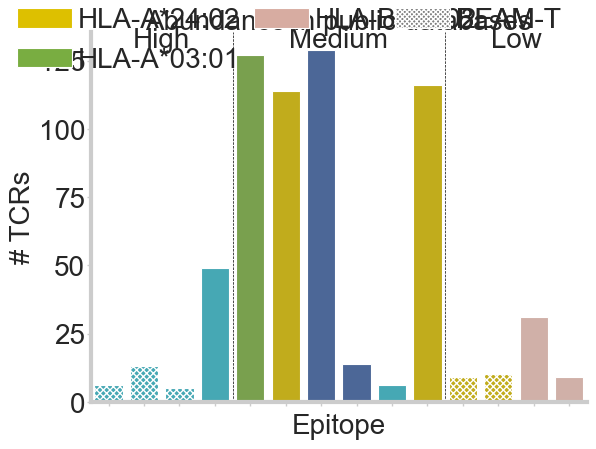

In [48]:
def plot_epitopes(ax=None):
    df_tmp = pd.DataFrame(df_data['Epitope'].value_counts())
    df_tmp['In VDJdb'] = df_tmp.index.map(lambda x: color_known if x in known_epitopes else color_unknown)
    df_tmp = df_tmp.rename(columns={'count': '# TCRs'})
    df_tmp['Epitope'] = df_tmp.index
    
    order = df_all_dbs.sort_values('CDR3_beta', ascending=False).index.tolist()
    plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=epitope_mhc_colors, order=order,
                     ax=ax)    
    labels = [el.get_text() for el in plot.get_xticklabels()]
    plot.set_xticklabels([])
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    
    custom_legend = [Patch(facecolor=c, label=l) for l, c in mhc_colors.items()]
    legend2 = plot.legend(handles=custom_legend, ncols=2, frameon=False, title='MHC',
                          columnspacing=0.5, handletextpad=0.2,
                         loc='upper left', bbox_to_anchor=(-0.2, 1.35))
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.set_ylabel('# TCRs', labelpad=2)
    
    for i, bar in enumerate(plot.patches):
        if labels[i] in epitopes_beamt:
            bar.set_hatch('xxxxx')
            
    hatch_description = {'Kocher et al.': None, 'BEAM-T': 'xxxxxxx'}
    custom_legend_2 = [Patch(facecolor='gray', label=l, hatch=h) for l, h in hatch_description.items()]
    legend1 = plot.legend(handles=custom_legend_2, frameon=False, title='Dataset',
                          columnspacing=0.5, handletextpad=0.2,
                          loc='upper right', bbox_to_anchor=(1.1, 1.35))
    plot.add_artist(legend1)
    plot.add_artist(legend2)
    
    for name, level in separtors_levels.items():
        if level > 0:
            plot.axvline(level, linestyle='--', color='black', linewidth=0.5)
            
    plot.set_title('Abundance in public databases', pad=2)
    
    groups = {
        'High': 1.5,
        'Medium': 6.5,
        'Low': 11.5,
    }
    for name, x in groups.items():
        plot.text(s=name, x=x, y=0.96, horizontalalignment='center', #weight='bold',
                 transform=plot.get_xaxis_transform())
plot_epitopes()

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\299688590.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.boxplot(data=df_tmp, x='Group', y='Value', ax=ax, order=order,
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\299688590.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels([el.get_text()[:3] for el in plot.get_xticklabels()], rotation=90)


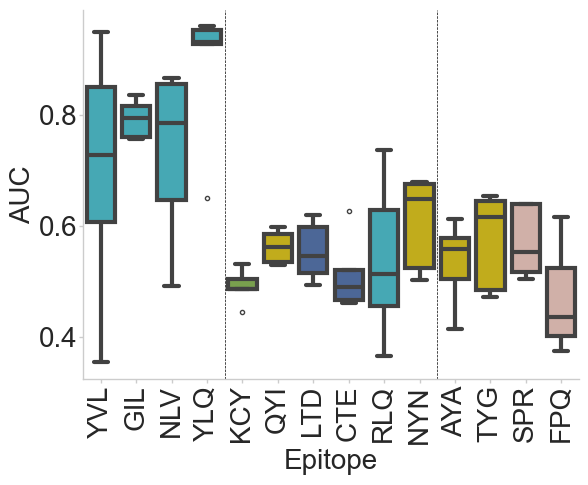

In [49]:
def plot_metric_by_epitope(df, metric, n_top=None, ax=None):
    df_tmp = df[df['Metric']==metric]
    if n_top:
        best_models = df_tmp[df_tmp['Group']=='WeightedAverage'].sort_values('Value')['BaseModel'][-n_top:].values
        df_tmp = df_tmp[df_tmp['BaseModel'].isin(best_models)]
    
    df_tmp = df_tmp[~df_tmp['Group'].isin(['Average', 'WeightedAverage', 'full_data'])]
    
    #order = df_data['Epitope'].value_counts().index.tolist()
    order = df_all_dbs.sort_values('CDR3_beta', ascending=False).index.tolist()
    plot = sb.boxplot(data=df_tmp, x='Group', y='Value', ax=ax, order=order,
                      palette=epitope_mhc_colors,
                      capprops = {"linewidth": utils_plot.LINEWIDTH},
                      flierprops={'markersize': 3},
                      medianprops = {'linewidth': utils_plot.LINEWIDTH},
                      boxprops={"linewidth": utils_plot.LINEWIDTH},
                      whiskerprops = {"linewidth": utils_plot.LINEWIDTH},)
    
    plot.set_xticklabels([el.get_text()[:3] for el in plot.get_xticklabels()], rotation=90)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel('Epitope')
    
    for name, level in separtors_levels.items():
        if level > 0:
            plot.axvline(level, linestyle='--', color='black', linewidth=0.5)

plot_metric_by_epitope(df_performance_best, 'AUC', 5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5822391433739936


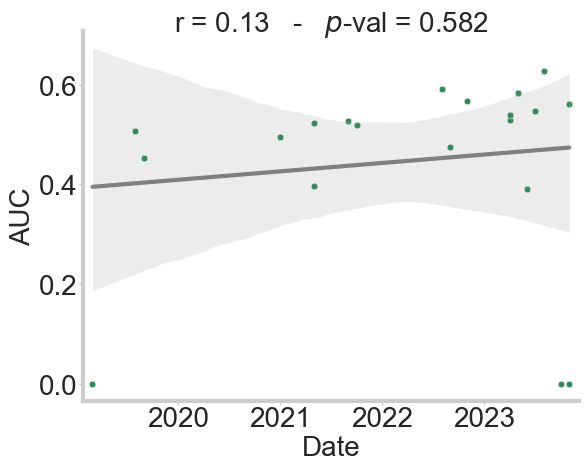

In [50]:
def plot_property_vs_performance(prop, metric, ax=None, size=None):
    df_scores = df_performance_best
    df_scores = df_scores[df_scores['Metric']==metric]
    df_scores = df_scores[df_scores['Group']=='full_data'].set_index('BaseModel')[['Value']]
    df_scores.index = df_scores.index.map(utils_config.mapper_methods)
    
    df_props = df_properties.set_index('Method')[[prop]]
    df_combined = pd.concat([df_scores, df_props], axis=1).fillna(0)
    
    plot = sb.scatterplot(data=df_combined, x=prop, y='Value',
                         s=size, color='seagreen', ax=ax)
    plot = sb.regplot(data=df_combined, 
                      x=prop, y='Value',
                      color='gray', ax=ax, 
                      scatter=False, line_kws={'zorder': -1, 'linewidth': utils_plot.LINEWIDTH})
    
    delta = df_combined[prop].max() - df_combined[prop].min()
    plot.set_xlim(df_combined[prop].min()-0.02*delta, df_combined[prop].max()+0.02*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel(prop, labelpad=2)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_combined[prop].values, df_combined['Value'].values)
    print(p_val)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_property_vs_performance('Date', 'AUC')

In [51]:
markers_epitope = {    
    'GILGFVFTL': 'o', 
    'YVLDHLIVV': 's',
    'NLVPMVATV': '^', 
    'YLQPRTFLL': 'v', 
    'RLQSLQTYV': 'p',
    
    'QYIKWPWYI': 'o', 
    'NYNYLYRLF': 's',
    'AYAQKIFKI': '^', 
    'TYGPVFMCL': 'p', 
    
    'LTDEMIAQY': 'o', 
    'CTELKLSDY': 's', 
    
    'SPRRARSVA': 'o', 
    'FPQSAPHGV': 's',
    
    'KCYGVSPTK': 'o',
}

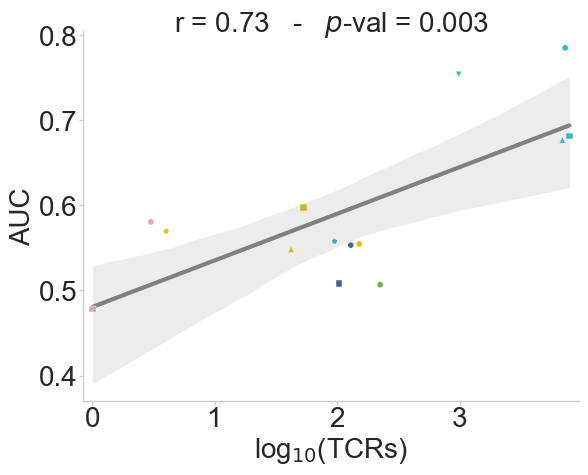

In [52]:
def plot_dbs_vs_performance(df, metric, n_top=5, ax=None):
    df_tmp = df[df['Metric']==metric]
    if n_top:
        best_models = df_tmp[df_tmp['Group']=='WeightedAverage'].sort_values('Value')['BaseModel'][-n_top:].values
        df_tmp = df_tmp[df_tmp['BaseModel'].isin(best_models)]
    
    df_tmp = df_tmp[~df_tmp['Group'].isin(['Average', 'WeightedAverage', 'full_data'])]
    df_tmp = df_tmp.groupby('Group')['Value'].mean()
    df_tmp = pd.DataFrame(df_tmp)
    df_tmp = pd.concat([df_tmp, df_all_dbs], axis=1).fillna(0)
    df_tmp['log(TCRs)'] = np.log10(1+df_tmp['CDR3_beta'])
    df_tmp['Epitope'] = df_tmp.index
 
    plot = sb.scatterplot(data=df_tmp, x='log(TCRs)', y='Value',
                          hue='Epitope', style='Epitope',
                          palette=epitope_mhc_colors, markers=markers_epitope,
                         s=20, color='seagreen', ax=ax)
    df_tmp = df_tmp.copy()
    plot = sb.regplot(data=df_tmp, x='log(TCRs)', y='Value',
                      color='gray', ax=ax, scatter=False, line_kws={'zorder': -1, 
                                                                    'linewidth': utils_plot.LINEWIDTH})
    delta = df_tmp['log(TCRs)'].max() - df_tmp['log(TCRs)'].min()
    plot.set_xlim(df_tmp['log(TCRs)'].min()-0.02*delta, df_tmp['log(TCRs)'].max()+0.02*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel('log$_{10}$(TCRs)', labelpad=2)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_tmp['log(TCRs)'].values, df_tmp['Value'].values)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_dbs_vs_performance(df_performance_best, 'AUC', 8)

In [53]:
df_performance_best['BaseModel'].value_counts()

BaseModel
bertrand      187
titan         187
tulip-tcr     187
attntap       187
dlptcr        187
epitcr        187
teinet        187
imrex         187
ergo-ii       187
ergo-i        187
tcellmatch    187
itcep         187
stapler       187
panpep        187
teim          187
pmtnet        187
atm-tcr       187
nettcr        187
Name: count, dtype: int64

## Figure Viral

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\2466653730.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=epitope_mhc_colors, order=order,
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:56: UserWarning: FixedFormatter should only be used together with Fix

0.5822391433739936


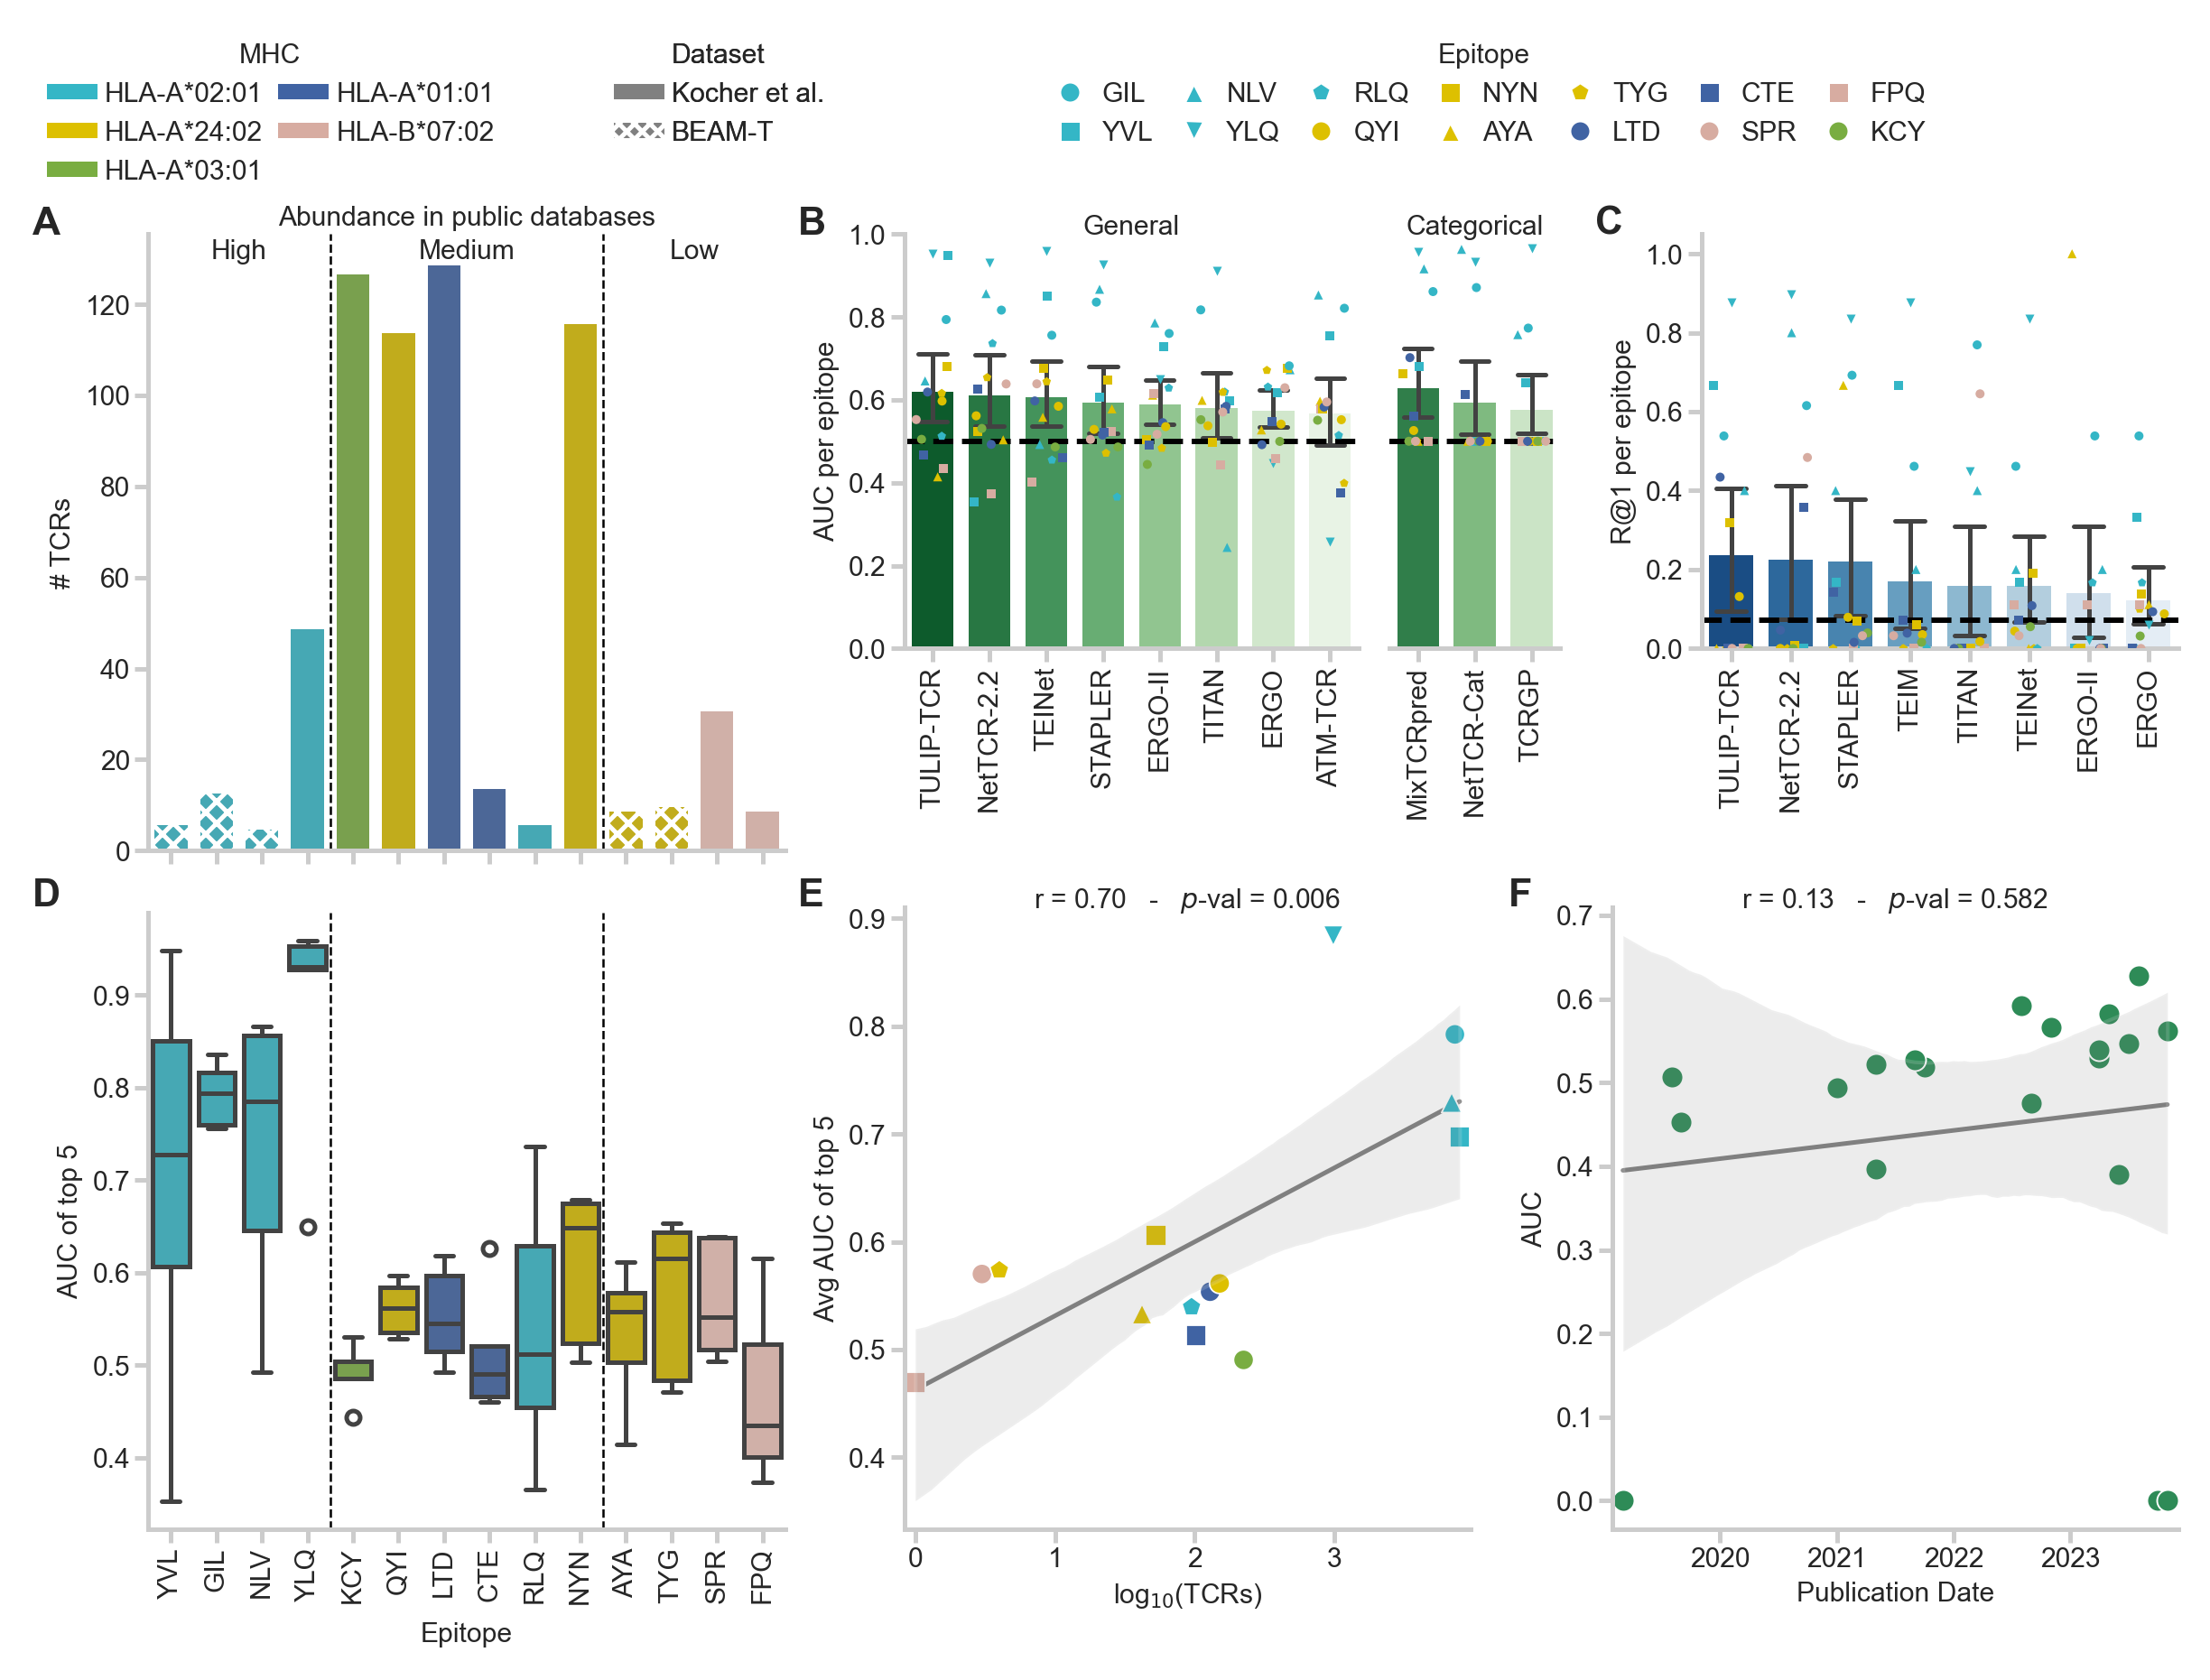

In [54]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.75), #0.65
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1,],
    width_ratios=[1, 2],
)

gridspecs["ad"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.],
    width_ratios=[1, ],
    hspace=0.1
)

gridspecs["bcef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.5],
    width_ratios=[1, ],
    hspace=0.5
)


gridspecs["bc"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['bcef'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[11, 8],
    wspace=0.25
)
gridspecs["b"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['bc'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[8, 3],
    wspace=0.1
)
gridspecs["ef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['bcef'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.25
)


ax_a = fig.add_subplot(gridspecs["ad"][0])
ax_b = fig.add_subplot(gridspecs["b"][0])
ax_b2 = fig.add_subplot(gridspecs["b"][1])
ax_c = fig.add_subplot(gridspecs["bc"][1])

ax_d = fig.add_subplot(gridspecs["ad"][1])
ax_e = fig.add_subplot(gridspecs["ef"][0])
ax_f = fig.add_subplot(gridspecs["ef"][1])


plot_epitopes(ax_a)
ax_a.set_xlabel(None)

plot_barplot(df_performance_best, 'AUC', n_top=8, cmap='Greens_r', ax=ax_b, rdm=0.5, 
             hue='Group', palette=epitope_mhc_colors, markers=markers_epitope)
ax_b.set_ylabel('AUC per epitope')
legend_handles = [plt.Line2D([0], [0], marker=markers_epitope[epi], color='w', 
                             markerfacecolor=epitope_mhc_colors[epi], markersize=5, label=epi[:3])
                  for epi in markers_epitope.keys()]
ax_b.legend(handles=legend_handles, ncols=7, frameon=False, title='Epitope',
            columnspacing=0.5, handletextpad=0.2,
            loc='upper left', bbox_to_anchor=(0.25, 1.52))
ax_b.set_ylim(0, 1)
ax_b.set_title('General', pad=0)

plot_barplot(df_performance_best_cat, 
             'AUC', n_top=3, cmap='Greens_r', ax=ax_b2, rdm=0.5,
             hue='Group', palette=epitope_mhc_colors, markers=markers_epitope)
ax_b2.set_ylim(0, 1)
ax_b2.legend().remove()
ax_b2.yaxis.set_visible(False)
ax_b2.spines['left'].set_visible(False)
ax_b2.set_title('Categorical', pad=0)

plot_barplot(df_performance_best, 'R@1', n_top=8, cmap='Blues_r', ax=ax_c, rdm=1/14, 
             hue='Group', palette=epitope_mhc_colors, markers=markers_epitope)
ax_c.set_ylabel('R@1 per epitope')
ax_c.legend().remove()

plot_metric_by_epitope(df_performance_best, 'AUC', 5, ax=ax_d)
ax_d.set_ylabel('AUC of top 5')
ax_d.set_xlabel('Epitope')

plot_dbs_vs_performance(df_performance_best, 'AUC', 5, ax=ax_e)
ax_e.set_ylabel('Avg AUC of top 5')

plot_property_vs_performance('Date', 'AUC', ax=None)
ax_f.set_xlabel('Publication Date')
ax_f.set_ylabel('AUC')

fig.text(0.005, 0.97, ' ', size='x-large', weight='bold', color='white')

fig.text(0.005, 0.88, 'A', size='x-large', weight='bold')
fig.text(0.355, 0.88, 'B', size='x-large', weight='bold')
fig.text(0.72, 0.88, 'C', size='x-large', weight='bold')

fig.text(0.005, 0.47, 'D', size='x-large', weight='bold')
fig.text(0.355, 0.47, 'E', size='x-large', weight='bold')
fig.text(0.68, 0.47, 'F', size='x-large', weight='bold')


fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig('../figures/fig_viral_benchmark.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/fig_viral_benchmark.png',
           dpi=DPI, bbox_inches='tight')

## SFigure 1 - All Models

D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90)
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Proje

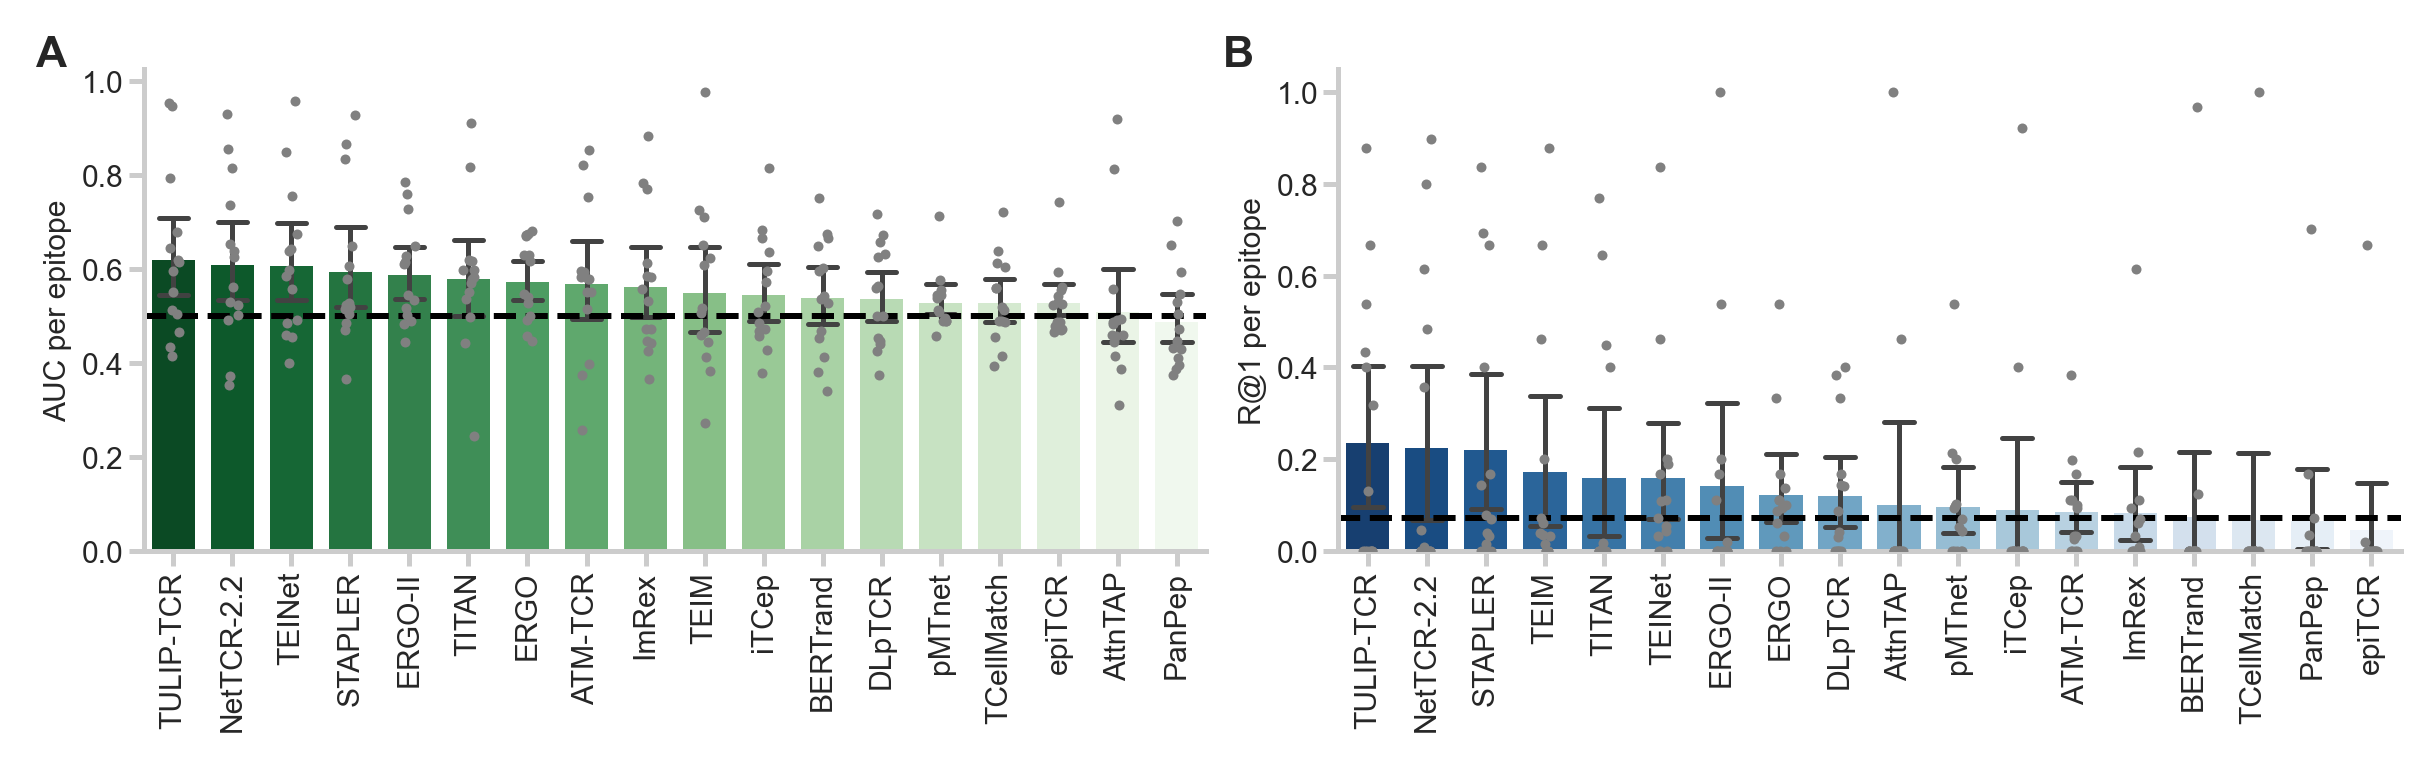

In [55]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.3),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1,],
    width_ratios=[1, 1],
)

ax_a = fig.add_subplot(gridspecs["full"][0])
ax_b = fig.add_subplot(gridspecs["full"][1])

plot_barplot(df_performance_best, 'AUC', n_top=18, cmap='Greens_r', ax=ax_a, rdm=0.5)
ax_a.set_ylabel('AUC per epitope')
plot_barplot(df_performance_best, 'R@1', n_top=18, cmap='Blues_r', ax=ax_b, rdm=1/14)
ax_b.set_ylabel('R@1 per epitope')

fig.text(0.01, 0.96, 'A', size='x-large', weight='bold')
fig.text(0.5, 0.96, 'B', size='x-large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_all.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_all.png',
           dpi=DPI, bbox_inches='tight')

## SFigure 2 - Model Alternatives

In [56]:
base_methods = sorted(df_performance_alt['BaseModel'].unique(), key=lambda x: x.lower())
colors_models = {m: met_brewer.met_brew(name='Signac', n=9, brew_type='discrete')[i]  # sb.color_palette('pastel')[i] 
                 for i, m in enumerate(base_methods)}

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1993412086.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1993412086.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1993412086.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90)


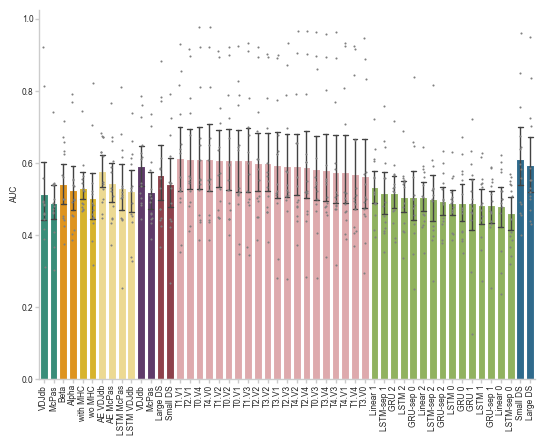

In [57]:
def plot_alternatives(df, metric, sort_by='Average', ax=None, rdm=None):
    df_plot = df[(df['Metric']==metric) & (~df['Group'].isin(['full_data', 'Average', 'WeightedAverage']))].copy()
    mean_perf = df_plot.groupby('Method')['Value'].mean().to_dict()
    df_plot['avgValue'] = df_plot['Method'].map(mean_perf)
    
    order = df[(df['Metric']=='AUC') & (df['Group']==sort_by)].sort_values(['BaseModel', 'Value'], ascending=[True, False],
                                                                           )['Method'].values
    
    order_base = df[(df['Metric']=='AUC') & (df['Group']==sort_by)].sort_values(['Method'])['BaseModel'].values
    palette = [colors_models[m] for m in order_base]

    plot = sb.barplot(data=df_plot, y='Value', x='Method',
                          order=order,
                          palette=palette,
                          errwidth=utils_plot.LINEWIDTH,
                          capsize=0.5,
                          ax=ax)
    plot = sb.stripplot(data=df_plot, y='Value', x='Method',
                          order=order,
                          color='gray',
                          size=1.5,
                          ax=ax)

    xlabels = plot.get_xticklabels()
    xlabels = [' '.join(el.get_text().split(' ')[1:]) for el in xlabels]
    plot.set_xticklabels(xlabels, rotation=90)

    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)

    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)

    if rdm is not None:
        plot.axhline(y=rdm, color='gray', linestyle='--')

plot_alternatives(df_performance_alt, 'AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1993412086.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1993412086.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1993412086.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1993412086.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

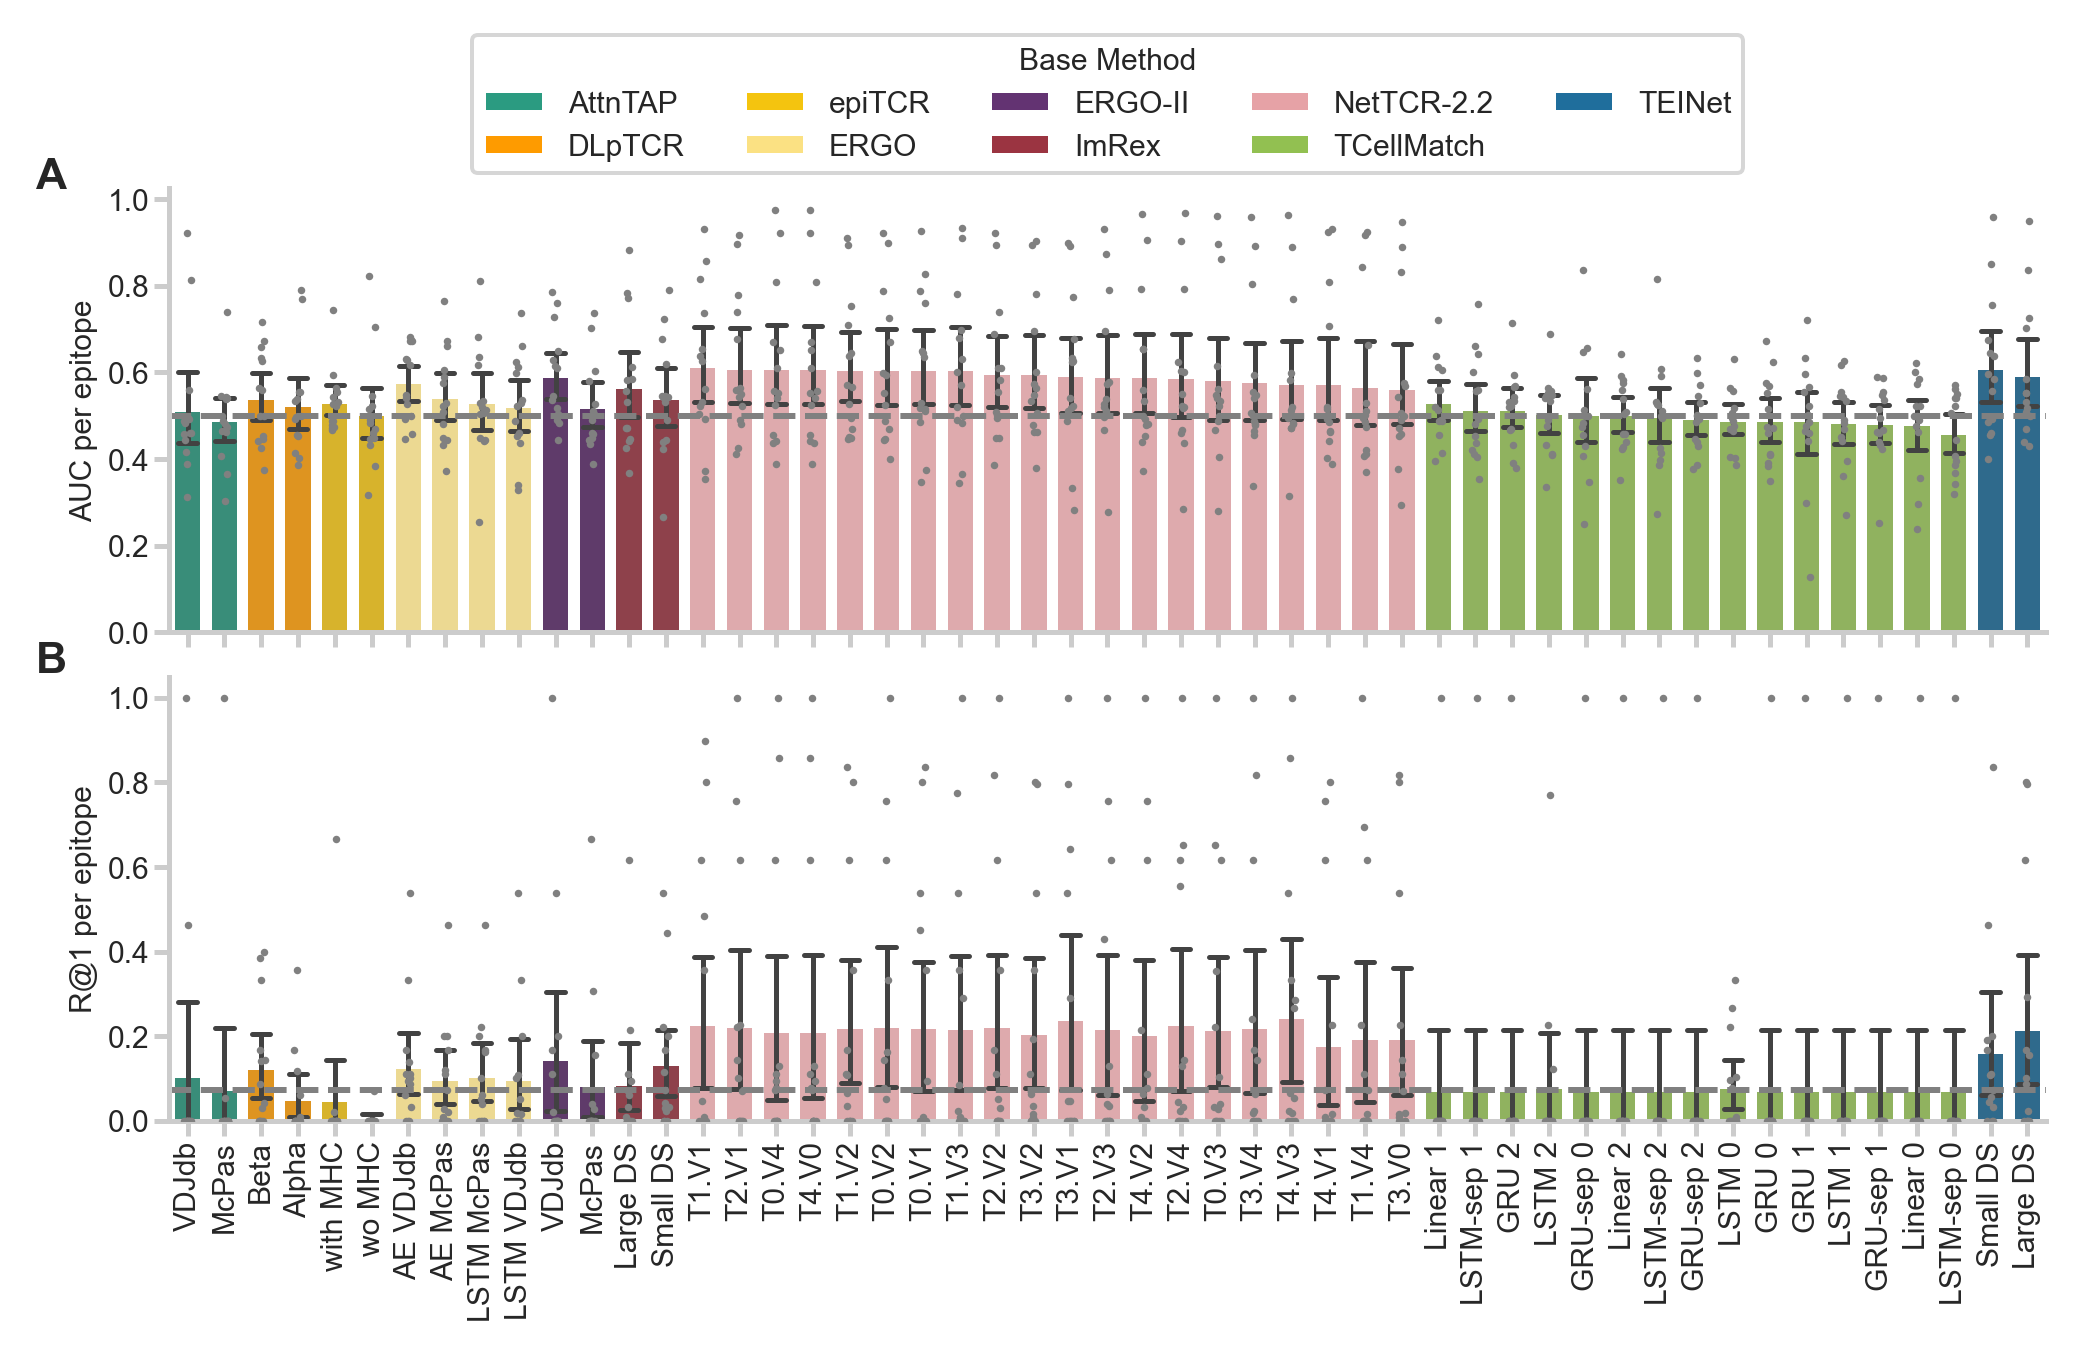

In [58]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.5),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
    hspace=0.1
)


for i, metric in enumerate(['AUC', 'R@1']):    
    ax_ = fig.add_subplot(gridspecs["full"][i])
    plot_alternatives(df_performance_alt, metric, sort_by='Average', ax=ax_, rdm=0.5 if i==0 else 1/14)
    ax_.set_ylabel(f'{metric} per epitope')
    
    if i == 0:
        ax_.set_xticklabels([])
        custom_legend = [Patch(facecolor=c, label=utils_config.mapper_methods[l]) for l, c in colors_models.items()]
        ax_.legend(handles=custom_legend, title='Base Method', ncol=5, bbox_to_anchor=(0.5, 1), loc='lower center')

fig.text(0.07, 0.88, 'A', size='x-large', weight='bold')
fig.text(0.07, 0.48, 'B', size='x-large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/sfig_viral_alternatives.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_alternatives.png',
           dpi=DPI, bbox_inches='tight')

## SFigure X - Positive vs Negative Scores

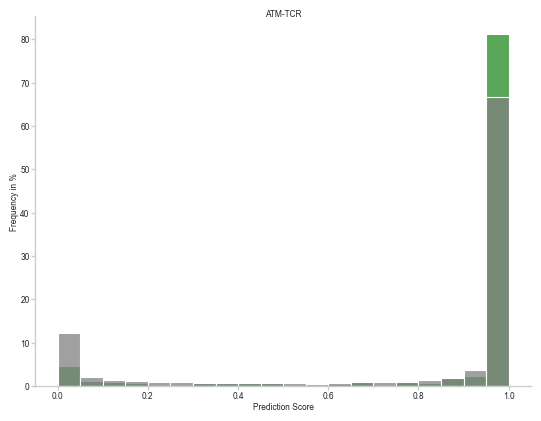

In [59]:
def plot_distribution(name, ax=None):
    n_bins = 20
    plot = sb.histplot(prediction_scores[prediction_scores['Label']==1], x=name, 
                      fill=True, color='forestgreen', label='Binding', stat='percent',
                      bins=n_bins,
                      common_norm=True, ax=ax)
    plot = sb.histplot(prediction_scores[prediction_scores['Label']==0], x=name, 
                      fill=True, color='gray', label='Non-binding', stat='percent',
                       bins=n_bins,
                      common_norm=True, ax=plot)
    
    plot.set_ylabel('Frequency in %', labelpad=1)
    plot.set_xlabel('Prediction Score', labelpad=1)
    plot.set_title(utils_config.mapper_methods[name.split('_')[0]], pad=0)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    
    sb.despine(ax=plot)
    plot.grid(False)
    
plot_distribution('atm-tcr')

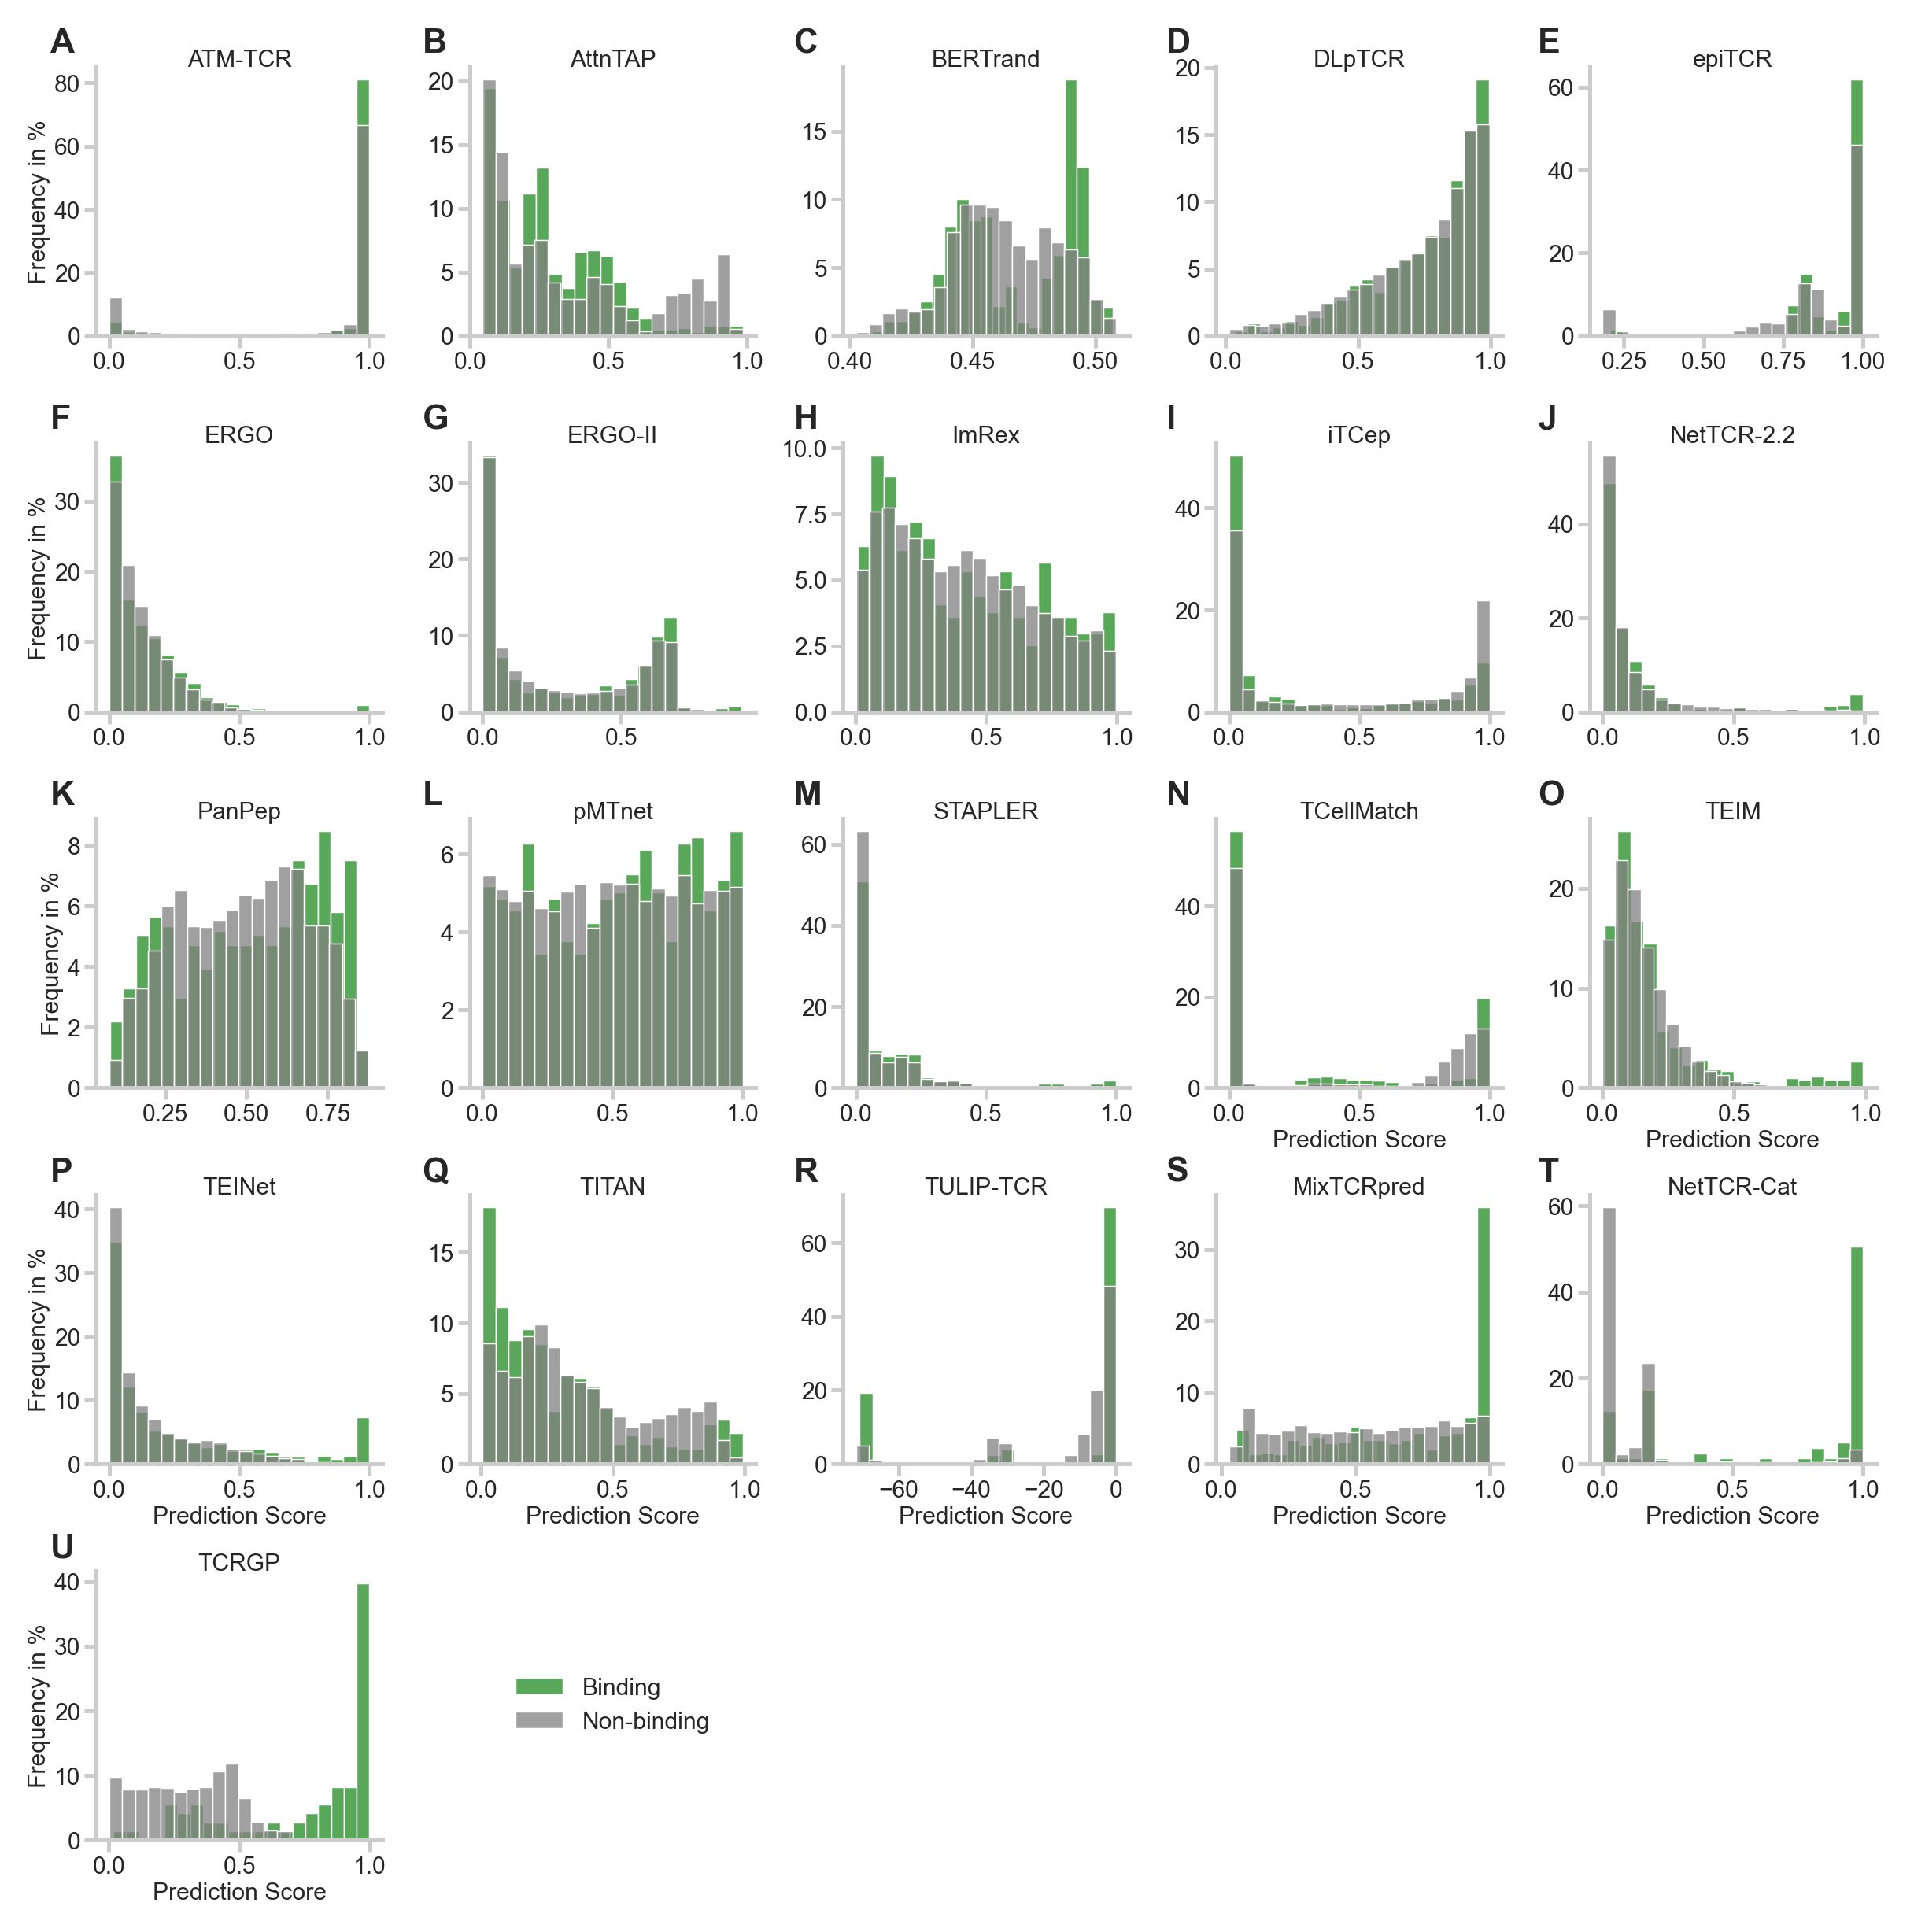

In [60]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 1),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=5,
    ncols=5,
    height_ratios=[1, 1, 1, 1, 1],
    width_ratios=[1, 1, 1, 1, 1],
)


letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for i, tag in enumerate(model_names_score):
    ax_tmp = fig.add_subplot(gridspecs["full"][i])
    plot_distribution(tag, ax_tmp)
    
    if i%5 != 0:
        ax_tmp.set_ylabel(None)
    if i < 13:
        ax_tmp.set_xlabel(None)
    
    fig.text(1/5.125*(i%5)+0.025, 0.985-i//5*0.1975, letters[i], size='x-large', weight='bold')
    

handles, labels = ax_tmp.get_legend_handles_labels()
ax_tmp = fig.add_subplot(gridspecs["full"][i+1])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, 0.5), frameon=False)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_distributions.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_distributions.png',
           dpi=DPI, bbox_inches='tight')

## SFigure X - Rank Distribution => Majority Class?

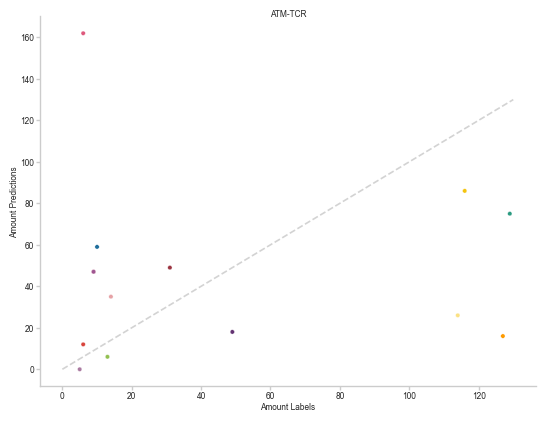

In [61]:
def plot_prediction_class(name, ax=None):
    df_counts = prediction_scores.sort_values(['clone_id', name], ascending=False)
    df_counts = df_counts.drop_duplicates(['clone_id', 'CDR3_alpha', 'CDR3_beta'], keep='first')['Epitope'].value_counts()
    df_counts = pd.DataFrame(df_counts)
    df_counts.columns = ['Amount Predictions']

    df_epis = pd.DataFrame(prediction_scores[prediction_scores['Label']==1]['Epitope'].value_counts())
    df_epis.columns = ['Amount Labels']
    df_counts = pd.concat([df_counts, df_epis], axis=1).fillna(0.0)
    df_counts['Epitope'] = df_counts.index
    df_counts = df_counts.sort_values('Amount Labels')
    
    plot = sb.scatterplot(data=df_counts, x='Amount Labels', y='Amount Predictions', hue='Epitope', 
                          palette=palette_epitopes, ax=ax, s=10)
    plot.plot([0, df_counts['Amount Labels'].max()+1], [0, df_counts['Amount Labels'].max()+1], 
              color='lightgrey', ls='--', zorder=-1)
    
    plot.set_ylabel('Amount Predictions', labelpad=1)
    plot.set_xlabel('Amount Labels', labelpad=1)
    plot.set_title(utils_config.mapper_methods[name.split('_')[0]], pad=0)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.legend().remove()
    
plot_prediction_class('atm-tcr', None)

scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.8),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=4,
    ncols=5,
    height_ratios=[1, 1, 1, 1],
    width_ratios=[1, 1, 1, 1, 1],
)


letters = 'abcdefghijklmnopqrstuvwxyz'
for i, tag in enumerate(model_names_score):
    ax_tmp = fig.add_subplot(gridspecs["full"][i])
    plot_prediction_class(tag, ax_tmp)
    
    if i%5 != 0:
        ax_tmp.set_ylabel(None)
    if i < 13:
        ax_tmp.set_xlabel(None)
    
    fig.text(1/5.125*(i%5)+0.025, 0.99-i//5*0.2425, letters[i], size='x-large', weight='bold')
    

handles, labels = ax_tmp.get_legend_handles_labels()
ax_tmp = fig.add_subplot(gridspecs["full"][i+1])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles[:7], labels=labels[:7], loc='center right', bbox_to_anchor=(1.1, 0.5), frameon=False)

ax_tmp = fig.add_subplot(gridspecs["full"][i+2])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles[-7:], labels=labels[-7:], loc='center left', bbox_to_anchor=(-0.1, 0.5), frameon=False)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_predictionClass.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_predictionClass.png',
           dpi=DPI, bbox_inches='tight')

### Average prediction score

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1445680598.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


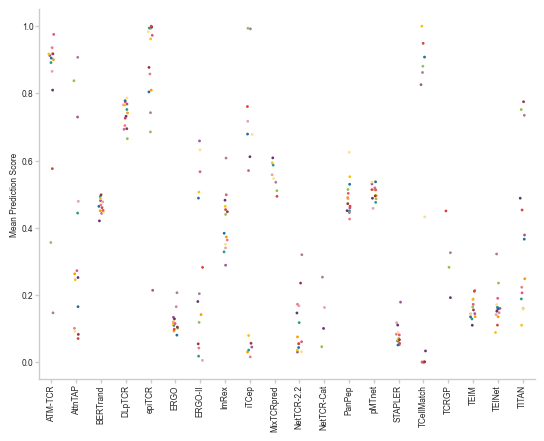

In [62]:
def plot_stats_prediction(stat, exclude=None, ax=None):
    df_tmp = prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-21:]]
    df_tmp = pd.melt(df_tmp, id_vars=['Epitope'], var_name='Method', value_name='Value')
    
    if stat.lower() == 'std':
        df_tmp = df_tmp.groupby(['Method', 'Epitope']).std()
    else:
        df_tmp = df_tmp.groupby(['Method', 'Epitope']).mean()
    df_tmp = df_tmp.reset_index()
    df_tmp['Dataset'] = df_tmp['Epitope'].apply(lambda x: 'Tumor' if x.startswith('R') else 'CMV')
    
    if exclude is not None:
        df_tmp = df_tmp[~df_tmp['Method'].isin(exclude)]
    df_tmp['Method'] = df_tmp['Method'].str.split('_').str[0]
    df_tmp['Method'] = df_tmp['Method'].map(utils_config.mapper_methods)
    
    plot = sb.stripplot(data=df_tmp, x='Method', y='Value',
                          hue='Epitope', palette=palette_epitopes,
                         size=2, ax=ax)
    
    sb.despine(ax=plot)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.grid(False)
    plot.set_ylabel(f'{stat} Prediction Score', labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend().remove()

plot_stats_prediction('Mean', ['tulip-tcr'])

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\2495406402.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


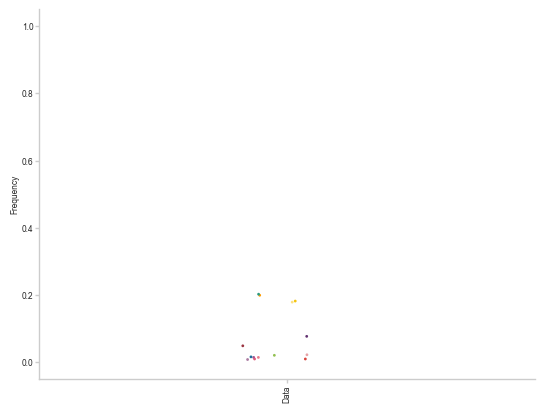

In [63]:
def plot_stats_data(stat, ax=None):
    df_tmp = prediction_scores[['Epitope', 'Label']]
    df_tmp = df_tmp.groupby('Epitope')['Label']
    if stat.lower() == 'std':
        df_tmp = df_tmp.std()
    else:
        df_tmp = df_tmp.mean()
    df_tmp = df_tmp.reset_index()
    df_tmp['Method'] = 'Data'

    plot = sb.stripplot(data=df_tmp, x='Method', y='Label',
                          hue='Epitope', palette=palette_epitopes,
                         size=2, ax=ax)
    
    sb.despine(ax=plot)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.grid(False)
    if stat.lower() == 'mean':
        plot.set_ylabel(f'Frequency', labelpad=2)
    else:
        plot.set_ylabel(f'Std', labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend().remove()
    plot.set_ylim(-0.05, 1.05)

plot_stats_data('Mean')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\2495406402.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1445680598.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1445680598.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1445680598.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\2495406402.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabe

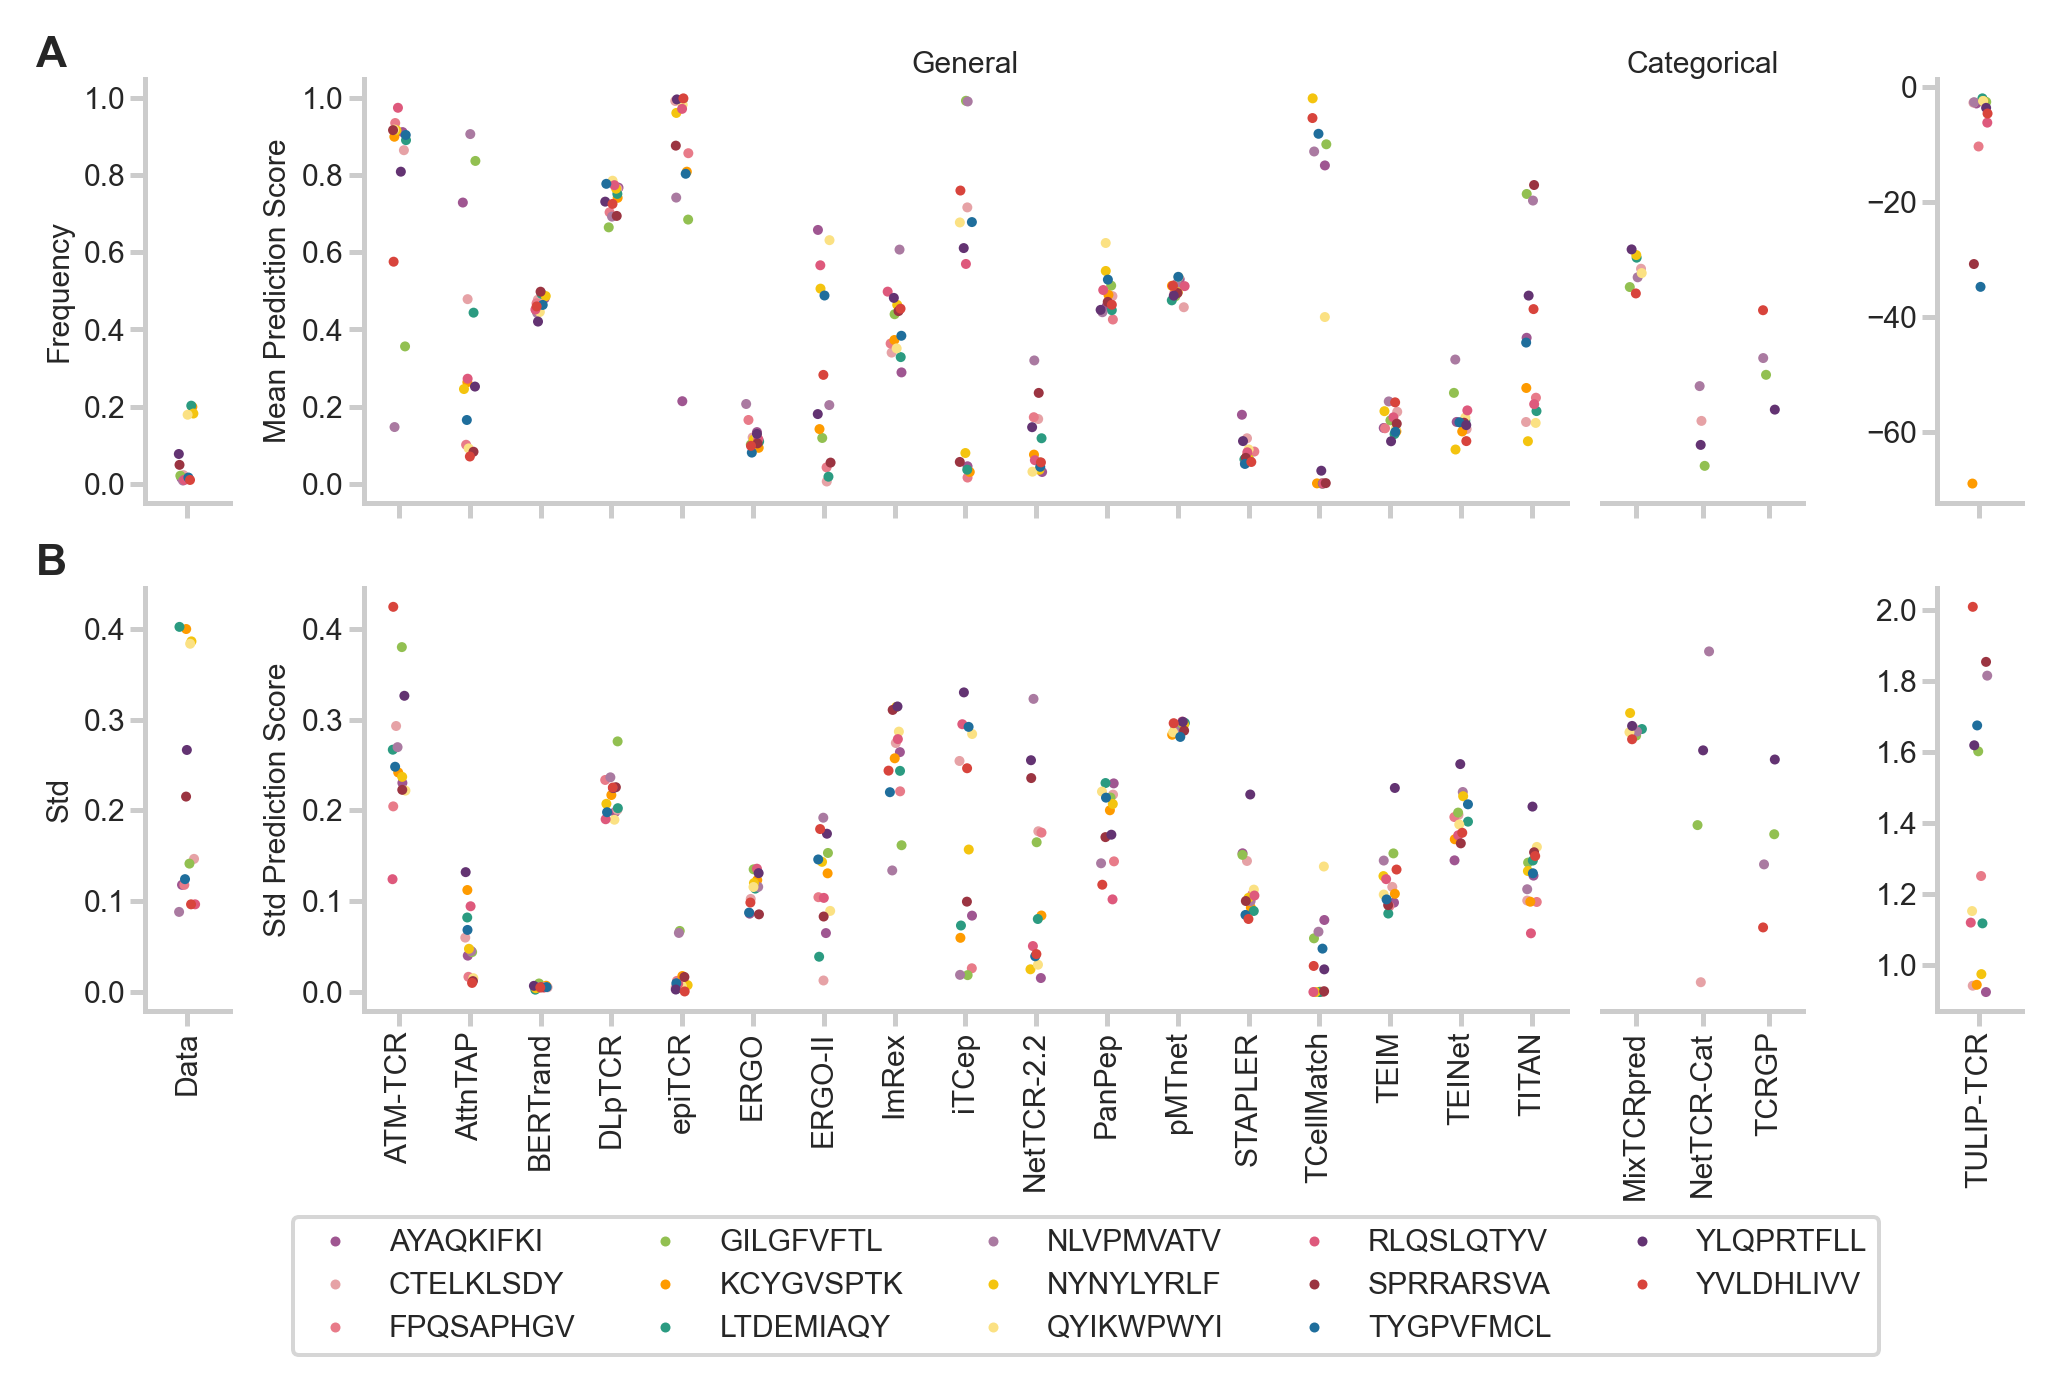

In [64]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.5),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=3,
    height_ratios=[1, 1,],
    width_ratios=[1, 17, 1],
    wspace=0.25
)
gridspecs["a2"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[18, 3],
    wspace=0.05
)
gridspecs["b2"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][4],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[18, 3],
    wspace=0.05
)

ax_a1 = fig.add_subplot(gridspecs["full"][0])
ax_a2 = fig.add_subplot(gridspecs["a2"][0])
ax_a22 = fig.add_subplot(gridspecs["a2"][1])
ax_a3 = fig.add_subplot(gridspecs["full"][2])
ax_b1 = fig.add_subplot(gridspecs["full"][3])
ax_b2 = fig.add_subplot(gridspecs["b2"][0])
ax_b22 = fig.add_subplot(gridspecs["b2"][1])
ax_b3 = fig.add_subplot(gridspecs["full"][5])
    
plot_stats_data('Mean', ax_a1)
plot_stats_prediction('Mean', ['tulip-tcr'] + best_models_cat, ax_a2)
plot_stats_prediction('Mean', [el for el in best_models], ax_a22)
plot_stats_prediction('Mean', [el for el in best_models if el != 'tulip-tcr'] + best_models_cat, ax_a3)
ax_a2.set_title('General', pad=0)
ax_a22.set_title('Categorical', pad=0)


plot_stats_data('Std', ax_b1)
plot_stats_prediction('Std', ['tulip-tcr'] + best_models_cat, ax_b2)
plot_stats_prediction('Std', [el for el in best_models], ax_b22)
plot_stats_prediction('Std', [el for el in best_models if el != 'tulip-tcr'] + best_models_cat, ax_b3)

ax_a1.set_xticklabels([])
ax_a2.set_xticklabels([])
ax_a22.set_xticklabels([])
ax_a3.set_xticklabels([])

ax_a22.set_ylabel(None)
ax_a3.set_ylabel(None)
ax_b22.set_ylabel(None)
ax_b3.set_ylabel(None)

ax_a22.spines["left"].set_visible(False)
ax_a22.yaxis.set_ticks([])
ax_b22.spines["left"].set_visible(False)
ax_b22.yaxis.set_ticks([])

ax_b2.legend(ncols=5, loc='upper center', bbox_to_anchor=(0.6, -0.45), frameon=True)

ax_a1.set_ylim(ax_a2.get_ylim())
ax_a22.set_ylim(ax_a2.get_ylim())
ax_b1.set_ylim(ax_b2.get_ylim())
ax_b22.set_ylim(ax_b2.get_ylim())
    
fig.text(0.08, 0.89, 'A', size='x-large', weight='bold')
fig.text(0.08, 0.47, 'B', size='x-large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/sfig_viral_predictionScores.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_predictionScores.png',
           dpi=DPI, bbox_inches='tight')

## Mean Performance vs on full data

In [65]:
colors_models = met_brewer.met_brew(name="Redon", n=18, brew_type="continuous")

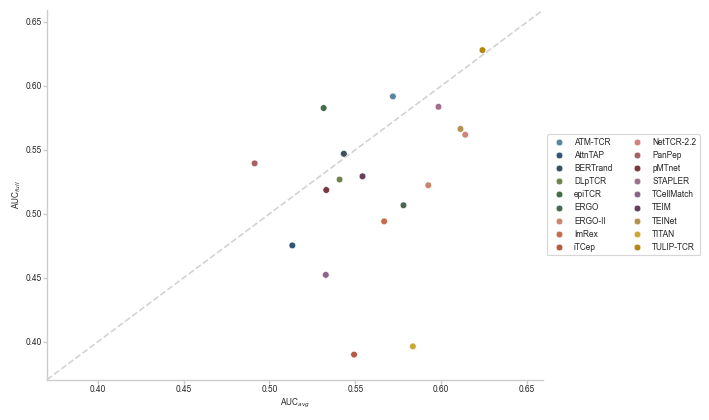

In [66]:
def plot_mean_vs_full(metric, ax=None, weighted=False):
    df_tmp = df_performance_best[(df_performance_best['Metric']==metric)
                                & (~df_performance_best['Group'].isin(['Average', 'WeightedAverage']))].copy()
    df_full = df_tmp[df_tmp['Group']=='full_data'][['BaseModel', 'Value']].set_index('BaseModel').copy()
    df_avg = df_tmp[df_tmp['Group']!='full_data'].copy()
    if weighted:
        df_avg['support'] = df_avg['Group'].map(amount_epis) / sum(amount_epis.values)
        df_avg['Value'] = df_avg['Value'] * df_avg['support'] 
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].sum())
    else:
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].mean())
    
    df_tmp = pd.concat([df_full, df_avg], axis=1)
    df_tmp.columns = ['full_data', 'averaged']
    df_tmp = df_tmp.reset_index()
    df_tmp = df_tmp.sort_values('BaseModel')
    df_tmp['BaseModel'] = df_tmp['BaseModel'].map(utils_config.mapper_methods)
    
    plot = sb.scatterplot(data=df_tmp, x='averaged', y='full_data', 
                          hue='BaseModel', palette=colors_models, ax=ax)
    
    max_ = df_tmp[['full_data', 'averaged']].max().max() * 1.05
    min_ = df_tmp[['full_data', 'averaged']].min().min() * 0.95
    plot.set_xlim((min_, max_))
    plot.set_ylim((min_, max_))
    
    plot.plot([min_, max_], [min_, max_], color='lightgrey', ls='--', zorder=-1)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_xlabel('AUC$_{avg}$', labelpad=2)
    plot.set_ylabel('AUC$_{full}$', labelpad=2)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend(ncols=2, loc='center left', bbox_to_anchor=(1, 0.5), )
    
plot_mean_vs_full('AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1656068671.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


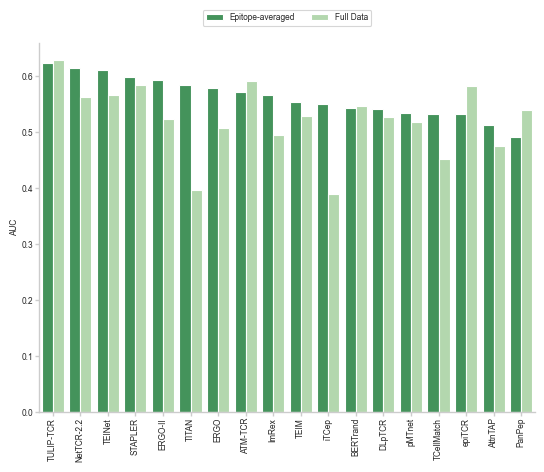

In [67]:
def plot_mean_vs_full_bar(metric, ax=None, weighted=False):
    df_tmp = df_performance_best[(df_performance_best['Metric']==metric)
                                & (~df_performance_best['Group'].isin(['Average', 'WeightedAverage']))].copy()
    df_full = df_tmp[df_tmp['Group']=='full_data'][['BaseModel', 'Value']].set_index('BaseModel').copy()
    df_avg = df_tmp[df_tmp['Group']!='full_data'].copy()
    if weighted:
        df_avg['support'] = df_avg['Group'].map(amount_epis) / sum(amount_epis.values)
        df_avg['Value'] = df_avg['Value'] * df_avg['support'] 
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].sum())
    else:
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].mean())
    
    df_avg['Type'] = 'Epitope-averaged'
    df_full['Type'] = 'Full Data'
    df_tmp = pd.concat([df_full, df_avg], axis=0)
    df_tmp = df_tmp.reset_index()
    df_tmp['BaseModel'] = df_tmp['BaseModel'].map(utils_config.mapper_methods)
    order = df_tmp[df_tmp['Type']=='Epitope-averaged'].sort_values('Value', ascending=False)['BaseModel'].values
    df_tmp['BaseModel'] = pd.Categorical(df_tmp['BaseModel'], categories=order, ordered=True)
    df_tmp = df_tmp.sort_values('BaseModel')
    
    plot = sb.barplot(data=df_tmp, x='BaseModel', y='Value', hue='Type',
                      palette='Greens_r', hue_order=['Epitope-averaged', 'Full Data'], ax=ax)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_xlabel(None)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.set_ylabel('AUC', labelpad=2)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    
plot_mean_vs_full_bar('AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\1656068671.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


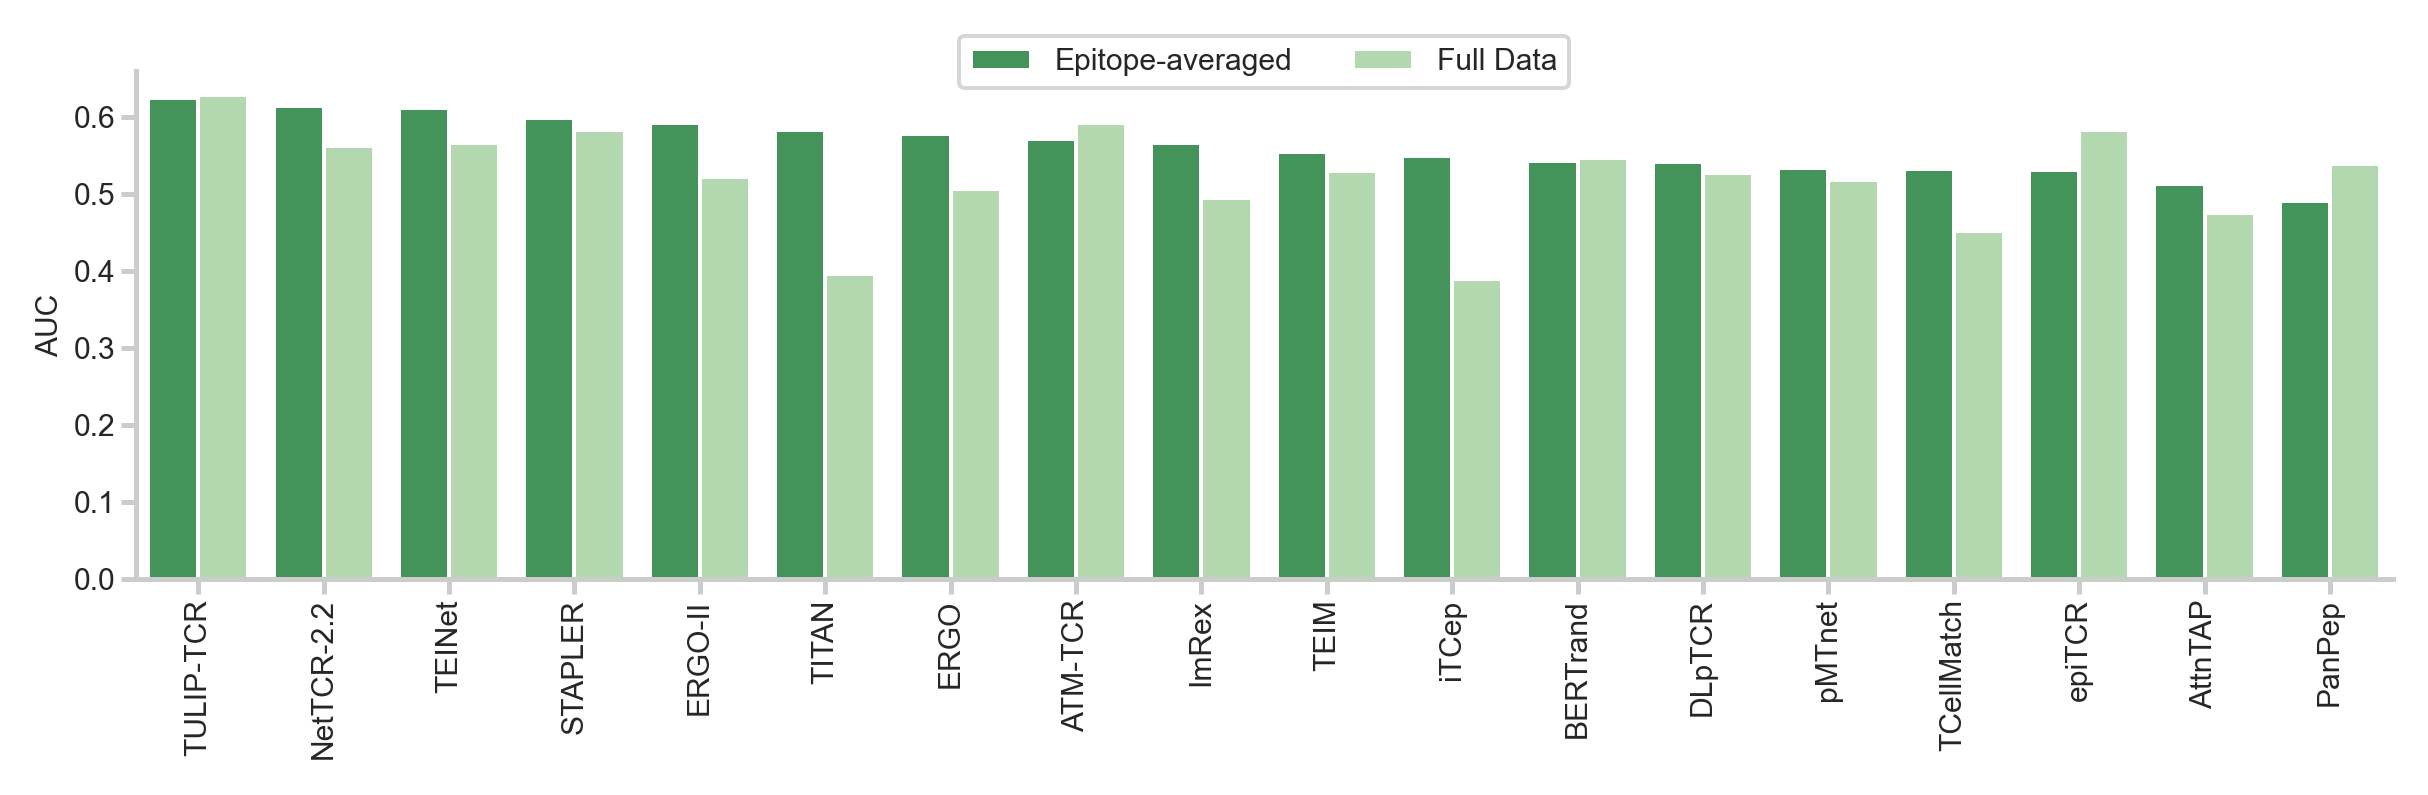

In [68]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.33),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=1,
    height_ratios=[1],
    width_ratios=[1],
)

ax_a = fig.add_subplot(gridspecs["full"][0])

plot_mean_vs_full_bar('AUC', ax_a)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_avg_vs_full.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_avg_vs_full.png',
           dpi=DPI, bbox_inches='tight')

## Influence properties

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.28922681551535545


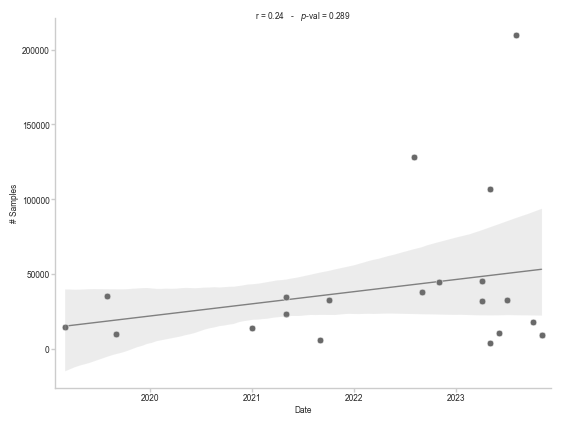

In [69]:
def plot_property_vs_property(prop, prop2, ax=None, size=None):    
    df_combined = df_properties.set_index('Method')[[prop, prop2]]
    
    plot = sb.scatterplot(data=df_combined, x=prop, y=prop2,
                         s=size, color='dimgrey', ax=ax)
    plot = sb.regplot(data=df_combined, 
                      x=prop, y=prop2,
                      color='gray', ax=ax, 
                      scatter=False, line_kws={'zorder': -1, 'linewidth': utils_plot.LINEWIDTH})
    
    delta = df_combined[prop].max() - df_combined[prop].min()
    plot.set_xlim(df_combined[prop].min()-0.02*delta, df_combined[prop].max()+0.02*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.set_ylabel(prop2, labelpad=2)
    plot.set_xlabel(prop, labelpad=2)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_combined[prop].values, df_combined[prop2].values)
    print(p_val)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_property_vs_property('Date', '# Samples')

In [70]:
palette_cats = {
    'Network Type': met_brewer.met_brew(name="Austria", n=6, brew_type="continuous"),
    'Pretraining': {True: 'goldenrod', False: 'silver'},
    'Negatives': met_brewer.met_brew(name="Austria")[1:],
    'CDR3':  met_brewer.met_brew(name="NewKingdom", n=2, brew_type="continuous"),
    'Gene Usage': {'True': 'goldenrod', 'False': 'silver', 'Full TCR': 'peru', 'CDR1-2': 'gold'},
    'MHC': {True: 'goldenrod', False: 'silver'},
    'Representation': met_brewer.met_brew(name="VanGogh2", n=4, brew_type="continuous"),
}

def plot_property_vs_performance_cat(prop, metric, ax=None):
    df_scores = df_performance_best[df_performance_best['Metric']==metric]
    df_scores = df_scores[df_scores['Group']=='full_data'].set_index('BaseModel')[['Value']]
    df_scores.index = df_scores.index.map(utils_config.mapper_methods)
    
    df_props = df_properties.set_index('Method')[[prop]]
    df_combined = pd.concat([df_scores, df_props], axis=1).fillna(0)
    
    plot = sb.swarmplot(data=df_combined, hue=prop, y='Value', palette=palette_cats[prop],
                         size=5, ax=ax)
    
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, bottom=True, left=prop in ['Network Type', 'Negatives'])
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel(prop, labelpad=2)
    plot.legend(loc='lower center', bbox_to_anchor=(1.0, 0.5), frameon=False, title=None, borderaxespad=0)

Palette 'Austria' has '7' discrete colors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.28922681551535545
0.08234524694608183


C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\3426997924.py:19: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plot = sb.swarmplot(data=df_combined, hue=prop, y='Value', palette=palette_cats[prop],
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_1912\3426997924.py:19: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  plot = sb.swarmplot(data=df_combined, hue=prop, y='Value', palette=palette_cats[prop],


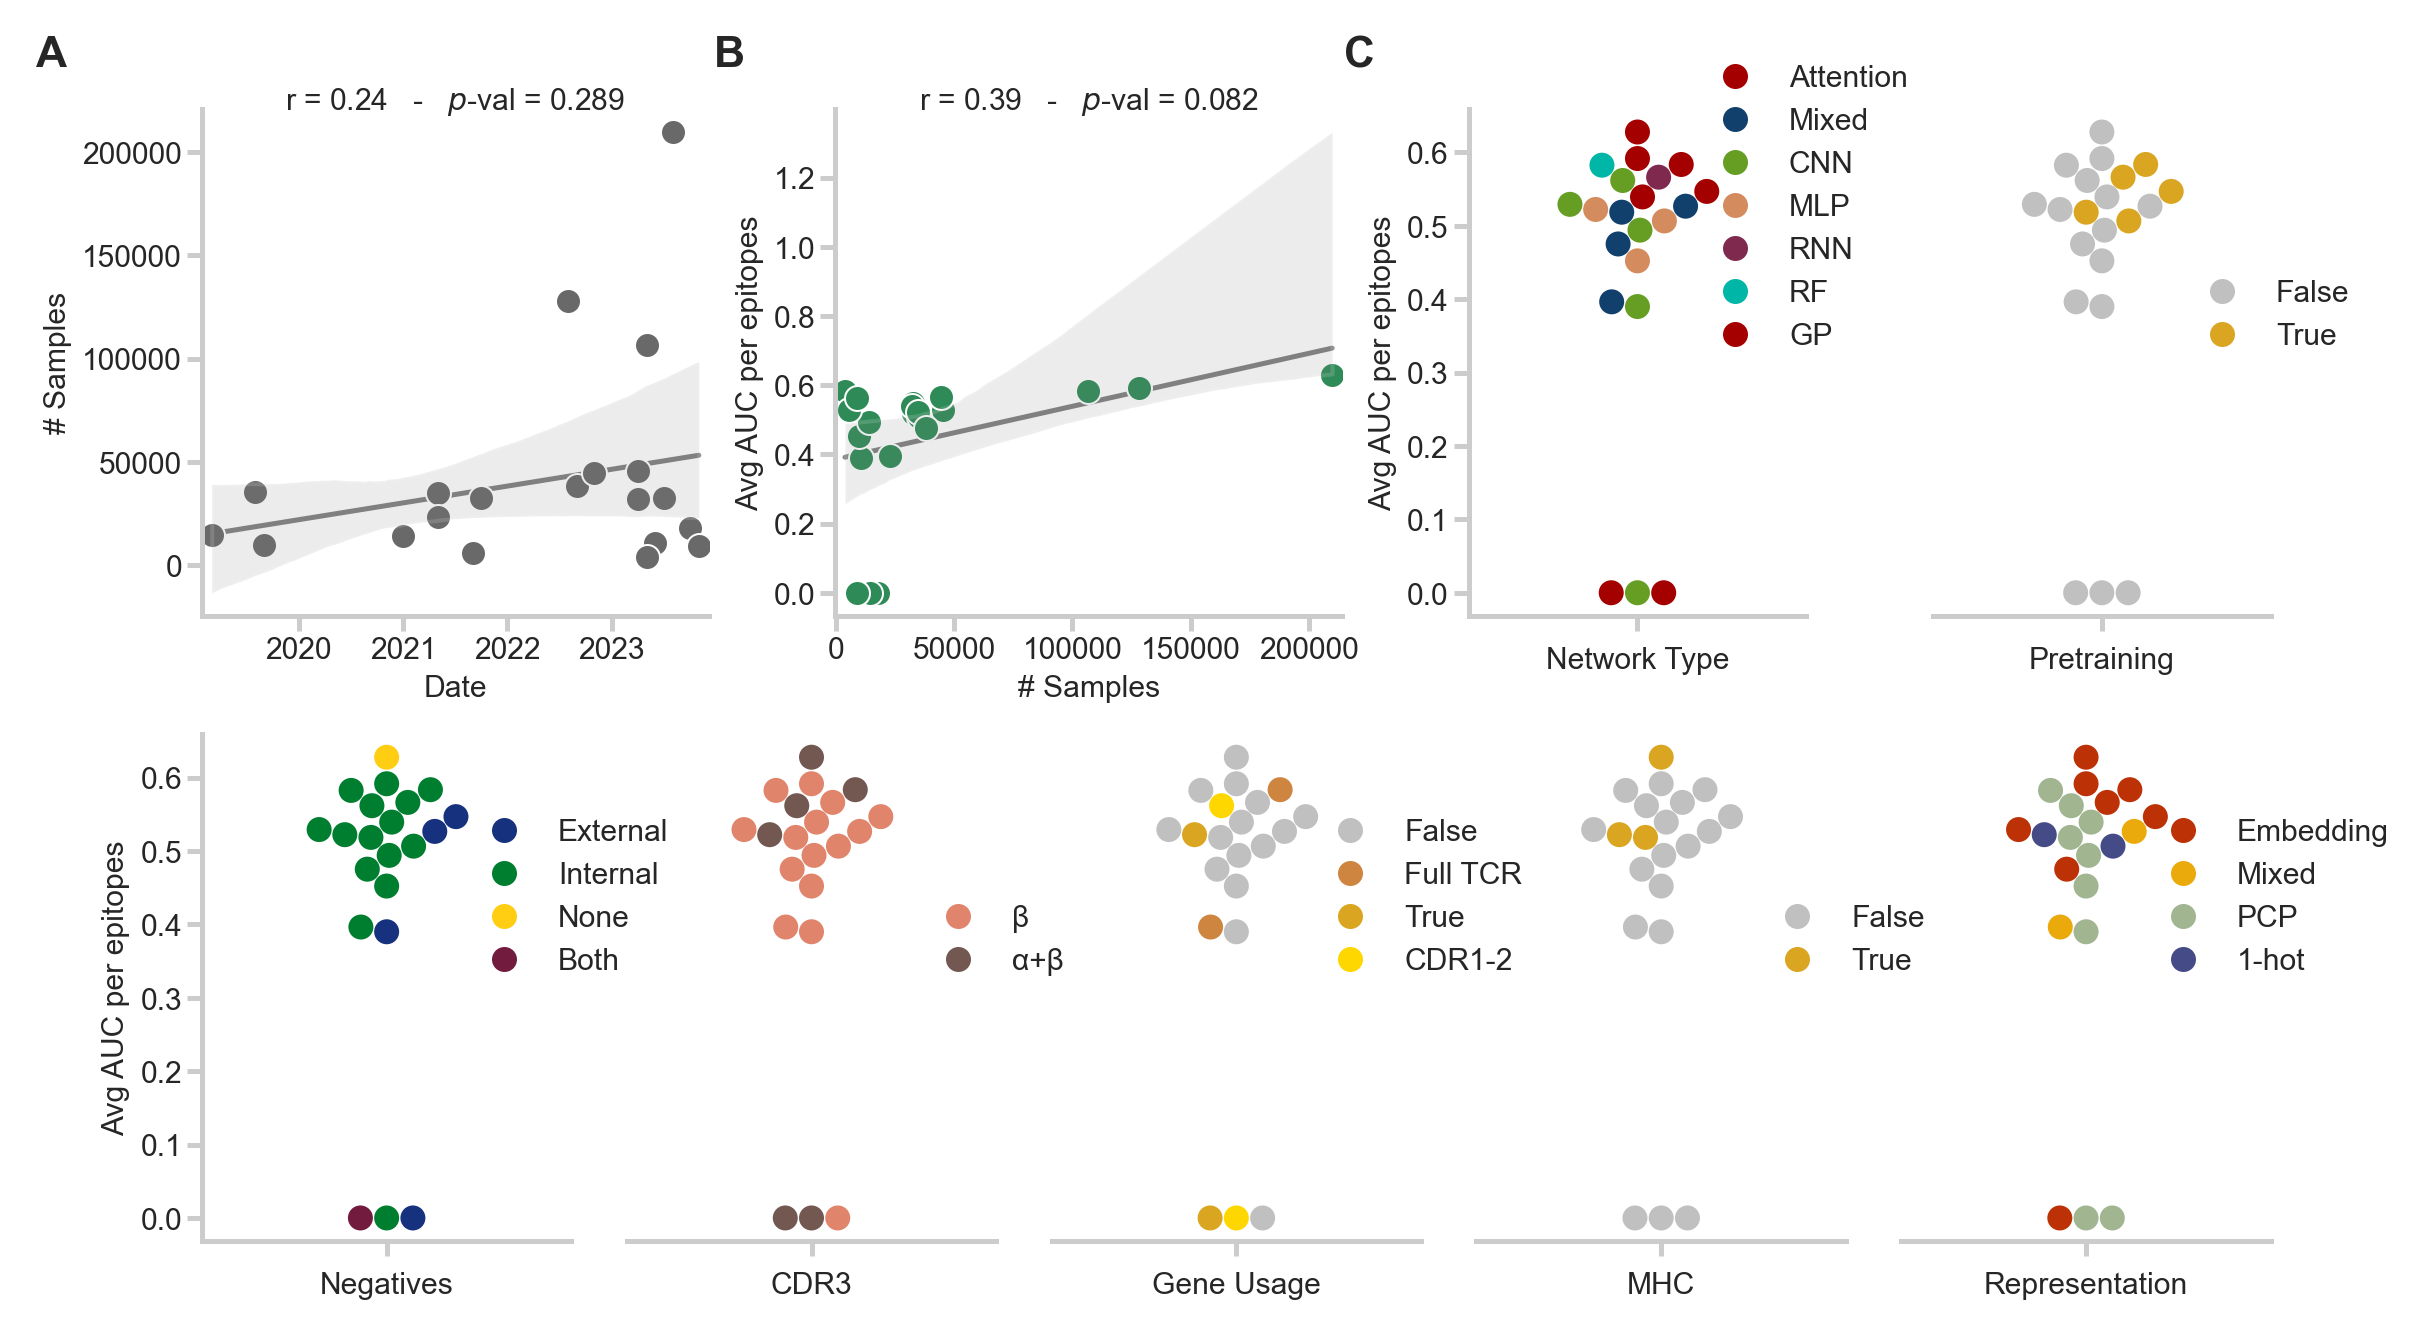

In [71]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.55),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
)
gridspecs["top"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][0],
    nrows=1,
    ncols=4,
    height_ratios=[1],
    width_ratios=[1.5, 1.5, 1, 1],
    wspace=0.30
)
gridspecs["bottom"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][1],
    nrows=1,
    ncols=5,
    height_ratios=[1],
    width_ratios=[1, 1, 1, 1, 1],
    wspace=0.15
)

ax_a = fig.add_subplot(gridspecs["top"][0])
plot_property_vs_property('Date', '# Samples', ax=ax_a, size=25)

ax_b = fig.add_subplot(gridspecs["top"][1])
plot_property_vs_performance('# Samples', 'AUC', ax=ax_b, size=25)
ax_b.set_ylabel('Avg AUC per epitopes')

for i, col in enumerate(reversed(['Network Type', 'Pretraining'])):
    ax = fig.add_subplot(gridspecs["top"][3-i])
    plot_property_vs_performance_cat(col, 'AUC', ax)
    if i != 1:
        sb.despine(ax=ax, left=True)
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Avg AUC per epitopes')
                        
                        
for i, col in enumerate(reversed(['Negatives', 'CDR3', 'Gene Usage', 'MHC', 'Representation'])):
    ax = fig.add_subplot(gridspecs["bottom"][4-i])
    plot_property_vs_performance_cat(col, 'AUC', ax)
    
    if i != 4: 
        sb.despine(ax=ax, left=True)
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Avg AUC per epitopes')
        
fig.text(0.01, 0.95, 'A', size='x-large', weight='bold')
fig.text(0.29, 0.95, 'B', size='x-large', weight='bold')
fig.text(0.55, 0.95, 'C', size='x-large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/sfig_viral_properties.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_properties.png', dpi=DPI, bbox_inches='tight')
plt.show()

## To Latex Table

In [72]:
from utils_latex import to_print_df, to_latex_string

In [73]:
metrics = ['AUC', 'APS', 'F1-Score', 'Rank', 'R@1', 'R@3']
df_print = to_print_df(df_performance_best, metrics, n_top=3)
df_print

Full Data                                               \
                      AUC            APS       F1-Score           Rank   
ATM-TCR     \textbf{0.59}           0.09           0.16  \textbf{6.28}   
AttnTAP              0.48           0.07           0.14           7.80   
BERTrand             0.55           0.09  \textbf{0.21}           6.92   
DLpTCR               0.53           0.08           0.14  \textbf{6.20}   
epiTCR               0.58           0.08           0.17           6.46   
ERGO                 0.51           0.09           0.13           7.45   
ERGO-II              0.52           0.09           0.14           7.35   
ImRex                0.49           0.08           0.13           7.68   
iTCep                0.39           0.05           0.13           8.93   
NetTCR-2.2           0.56           0.11           0.15           7.02   
PanPep               0.54           0.09           0.16           6.59   
pMTnet               0.52           0.08           0.14           7.27   
STAPLER     \textbf{0.58}  \textbf{0.15}           0.16           6.42   
TCellMatch           0.45           0.08           0.18           8.11   
TEIM                 0.53           0.14           0.15           7.03   
TEINet               0.57  \textbf{0.19}  \textbf{0.19}           6.81   
TITAN                0.40           0.07           0.13           8.88   
TULIP-TCR   \textbf{0.63}  \textbf{0.25}  \textbf{0.26}  \textbf{6.00}   

                                                 Per Epitope  \
                      R@1            R@3                 AUC   
ATM-TCR              0.08           0.28           0.57±0.16   
AttnTAP              0.02           0.04           0.51±0.16   
BERTrand             0.07  \textbf{0.43}           0.54±0.12   
DLpTCR               0.13           0.30           0.54±0.11   
epiTCR               0.01           0.18           0.53±0.07   
ERGO                 0.09           0.25           0.58±0.09   
ERGO-II              0.03           0.28           0.59±0.11   
ImRex                0.09           0.24           0.57±0.15   
iTCep                0.02           0.10           0.55±0.12   
NetTCR-2.2           0.13           0.23  \textbf{0.61±0.17}   
PanPep               0.13  \textbf{0.32}           0.49±0.10   
pMTnet               0.08           0.24           0.53±0.06   
STAPLER              0.13           0.31           0.60±0.17   
TCellMatch  \textbf{0.18}           0.21           0.53±0.09   
TEIM                 0.12           0.26           0.55±0.18   
TEINet      \textbf{0.16}           0.32  \textbf{0.61±0.16}   
TITAN                0.09           0.16           0.58±0.15   
TULIP-TCR   \textbf{0.26}  \textbf{0.44}  \textbf{0.62±0.17}   

                                                                        \
                           APS            F1-Score                Rank   
ATM-TCR              0.13±0.13  \textbf{0.15±0.14}           6.86±2.01   
AttnTAP              0.12±0.16           0.10±0.13           7.29±4.20   
BERTrand             0.12±0.13           0.06±0.13           7.35±4.05   
DLpTCR               0.08±0.08           0.13±0.13           6.85±2.40   
epiTCR               0.07±0.08           0.08±0.13           7.46±4.13   
ERGO                 0.13±0.14           0.13±0.12           6.36±1.71   
ERGO-II              0.13±0.12           0.13±0.14           6.78±4.00   
ImRex                0.12±0.12           0.12±0.13           7.12±2.09   
iTCep                0.11±0.14           0.12±0.13           7.23±3.93   
NetTCR-2.2           0.17±0.22           0.14±0.13  \textbf{5.97±3.05}   
PanPep               0.09±0.12           0.09±0.12           7.60±2.60   
pMTnet               0.10±0.10           0.12±0.12           6.93±1.06   
STAPLER     \textbf{0.19±0.25}           0.15±0.14  \textbf{5.90±2.19}   
TCellMatch           0.08±0.08           0.02±0.08           7.50±4.18   
TEIM                 0.17±0.24           0.12±0.22           6.25±3.00

In [74]:
to_latex_string(df_print)

\begin{table}[ht]
\resizebox{\textwidth}{!}{%}
\centering
\begin{tabular}{l l l l l l l | l l l l l l}
\toprule
 & Full Data &   &   &   &   &   & Per Epitope &   &   &   &   &   \\
  & AUC & APS & F1-Score & Rank & R@1 & R@3 & AUC & APS & F1-Score & Rank & R@1 & R@3 \\
\midrule
ATM-TCR & \textbf{0.59} & 0.09 & 0.16 & \textbf{6.28} & 0.08 & 0.28 & 0.57±0.16 & 0.13±0.13 & \textbf{0.15±0.14} & 6.86±2.01 & 0.09±0.11 & 0.26±0.18 \\
AttnTAP & 0.48 & 0.07 & 0.14 & 7.80 & 0.02 & 0.04 & 0.51±0.16 & 0.12±0.16 & 0.10±0.13 & 7.29±4.20 & 0.10±0.29 & 0.21±0.43 \\
BERTrand & 0.55 & 0.09 & \textbf{0.21} & 6.92 & 0.07 & \textbf{0.43} & 0.54±0.12 & 0.12±0.13 & 0.06±0.13 & 7.35±4.05 & 0.08±0.26 & 0.21±0.42 \\
DLpTCR & 0.53 & 0.08 & 0.14 & \textbf{6.20} & 0.13 & 0.30 & 0.54±0.11 & 0.08±0.08 & 0.13±0.13 & 6.85±2.40 & 0.12±0.15 & 0.25±0.21 \\
epiTCR & 0.58 & 0.08 & 0.17 & 6.46 & 0.01 & 0.18 & 0.53±0.07 & 0.07±0.08 & 0.08±0.13 & 7.46±4.13 & 0.05±0.18 & 0.20±0.35 \\
ERGO & 0.51 & 0.09 & 0.13 & 7.45 & 0.09 & 

In [75]:
(df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('BaseModel')['Value'].mean()<0.55).sum()

8

In [76]:
models_bad = (df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('BaseModel')['Value'].mean()<0.55)
models_bad = models_bad[models_bad].index.tolist()
models_bad

['attntap',
 'bertrand',
 'dlptcr',
 'epitcr',
 'itcep',
 'panpep',
 'pmtnet',
 'tcellmatch']

In [77]:
outliers = df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
    & (df_performance_best['BaseModel'].isin(models_bad))
    & (df_performance_best['Value'] >= 0.7)
]
print(outliers['Group'].value_counts())
print()
print(outliers['BaseModel'].value_counts())

Group
YLQPRTFLL    3
GILGFVFTL    2
RLQSLQTYV    2
NYNYLYRLF    1
CTELKLSDY    1
Name: count, dtype: int64

BaseModel
attntap       2
bertrand      1
pmtnet        1
panpep        1
itcep         1
tcellmatch    1
epitcr        1
dlptcr        1
Name: count, dtype: int64


In [78]:
df_performance_best[
 (df_performance_best['BaseModel'].isin(models_bad)) &
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('BaseModel')['Value'].mean()

BaseModel
attntap       0.513319
bertrand      0.543320
dlptcr        0.540816
epitcr        0.531559
itcep         0.549261
panpep        0.491352
pmtnet        0.533070
tcellmatch    0.532807
Name: Value, dtype: float64

In [79]:
df_tmp = df_performance_best[
    (df_performance_best['BaseModel'].isin(models_bad)) &
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')]
df_tmp.groupby('BaseModel')['Value'].max()

BaseModel
attntap       0.920723
bertrand      0.751464
dlptcr        0.717147
epitcr        0.743012
itcep         0.814681
panpep        0.701843
pmtnet        0.712554
tcellmatch    0.722046
Name: Value, dtype: float64

In [80]:
df_tmp = df_performance_best[
    (df_performance_best['BaseModel'].isin(['attntap'])) &
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')]
df_tmp

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant,Group_short
77,attntap_VDJDB,Viral,AYAQKIFKI,638,TTP,AUC,0.444444,attntap,VDJDB,AYA
79,attntap_VDJDB,Viral,GILGFVFTL,638,TTP,AUC,0.814338,attntap,VDJDB,GIL
81,attntap_VDJDB,Viral,YLQPRTFLL,638,TTP,AUC,0.920723,attntap,VDJDB,YLQ
83,attntap_VDJDB,Viral,YVLDHLIVV,638,TTP,AUC,0.388449,attntap,VDJDB,YVL
85,attntap_VDJDB,Viral,LTDEMIAQY,638,TTP,AUC,0.493748,attntap,VDJDB,LTD
87,attntap_VDJDB,Viral,QYIKWPWYI,638,TTP,AUC,0.459020,attntap,VDJDB,QYI
89,attntap_VDJDB,Viral,RLQSLQTYV,638,TTP,AUC,0.460707,attntap,VDJDB,RLQ
91,attntap_VDJDB,Viral,SPRRARSVA,638,TTP,AUC,0.483499,attntap,VDJDB,SPR
93,attntap_VDJDB,Viral,TYGPVFMCL,638,TTP,AUC,0.558280,attntap,VDJDB,TYG
95,attntap_VDJDB,Viral,NLVPMVATV,638,TTP,AUC,0.311374,attntap,VDJDB,NLV


In [81]:
df_performance_best[
    (df_performance_best['Group']=='YLQPRTFLL')
    & (df_performance_best['Metric']=='AUC')
].sort_values('Value', ascending=False).head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant,Group_short
81,teim,Viral,YLQPRTFLL,638,TTP,AUC,0.976751,teim,,YLQ
81,teinet_SMALL_DS,Viral,YLQPRTFLL,638,TTP,AUC,0.959149,teinet,SMALL_DS,YLQ
81,tulip-tcr,Viral,YLQPRTFLL,638,TTP,AUC,0.953293,tulip-tcr,,YLQ
81,nettcr_t.1.v.0,Viral,YLQPRTFLL,638,TTP,AUC,0.930460,nettcr,t.1.v.0,YLQ
81,stapler,Viral,YLQPRTFLL,638,TTP,AUC,0.927619,stapler,,YLQ


In [82]:
(prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-21:]
                 ].groupby('Epitope').mean()>0.5).sum()

atm-tcr                      12
attntap_VDJDB                 3
bertrand                      0
dlptcr_BETA                  14
epitcr_WITH_MHC              13
ergo-i_AE_VDJDB               0
ergo-ii_VDJDB                 4
imrex_FULL                    1
itcep                         8
nettcr_t.1.v.0                0
panpep                        5
pmtnet                        7
stapler                       0
tcellmatch_LINEAR_CV1         6
teim                          0
teinet_SMALL_DS               0
titan                         3
tulip-tcr                     0
mixtcrpred                    7
nettcrcat_peptide_t.0.v.1     0
tcrgp                         0
dtype: int64

In [83]:
(prediction_scores[prediction_scores.columns.tolist()[-21:]
                 ].mean()>0.5).sum()

5

In [84]:
df_data['Epitope'].value_counts(normalize=True)

Epitope
LTDEMIAQY    0.202194
KCYGVSPTK    0.199060
NYNYLYRLF    0.181818
QYIKWPWYI    0.178683
YLQPRTFLL    0.076803
SPRRARSVA    0.048589
CTELKLSDY    0.021944
GILGFVFTL    0.020376
TYGPVFMCL    0.015674
AYAQKIFKI    0.014107
FPQSAPHGV    0.014107
YVLDHLIVV    0.009404
RLQSLQTYV    0.009404
NLVPMVATV    0.007837
Name: proportion, dtype: float64

In [85]:
prediction_scores[['Epitope', 'Label']].groupby('Epitope')['Label'].std().sort_values()

Epitope
NLVPMVATV    0.088248
RLQSLQTYV    0.096595
YVLDHLIVV    0.096595
FPQSAPHGV    0.118023
AYAQKIFKI    0.118023
TYGPVFMCL    0.124308
GILGFVFTL    0.141394
CTELKLSDY    0.146614
SPRRARSVA    0.215177
YLQPRTFLL    0.266487
QYIKWPWYI    0.383388
NYNYLYRLF    0.385997
KCYGVSPTK    0.399606
LTDEMIAQY    0.401952
Name: Label, dtype: float64

In [86]:
prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-21:]
                 ].groupby('Epitope').std().mean()<0.1

atm-tcr                      False
attntap_VDJDB                 True
bertrand                      True
dlptcr_BETA                  False
epitcr_WITH_MHC               True
ergo-i_AE_VDJDB              False
ergo-ii_VDJDB                False
imrex_FULL                   False
itcep                        False
nettcr_t.1.v.0               False
panpep                       False
pmtnet                       False
stapler                      False
tcellmatch_LINEAR_CV1         True
teim                         False
teinet_SMALL_DS              False
titan                        False
tulip-tcr                    False
mixtcrpred                   False
nettcrcat_peptide_t.0.v.1    False
tcrgp                        False
dtype: bool

In [87]:
prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-21:]
                 ].groupby('Epitope').mean().mean()<0.2

atm-tcr                      False
attntap_VDJDB                False
bertrand                     False
dlptcr_BETA                  False
epitcr_WITH_MHC              False
ergo-i_AE_VDJDB               True
ergo-ii_VDJDB                False
imrex_FULL                   False
itcep                        False
nettcr_t.1.v.0                True
panpep                       False
pmtnet                       False
stapler                       True
tcellmatch_LINEAR_CV1        False
teim                          True
teinet_SMALL_DS               True
titan                        False
tulip-tcr                     True
mixtcrpred                   False
nettcrcat_peptide_t.0.v.1     True
tcrgp                        False
dtype: bool

## Latex Table: AUC per predictor

In [88]:
epitope_groups = {
    'YVLDHLIVV': 'High',
    'GILGFVFTL': 'High',
    'NLVPMVATV': 'High',
    'YLQPRTFLL': 'High',
    'KCYGVSPTK': 'Medium',
    'QYIKWPWYI': 'Medium',
    'LTDEMIAQY': 'Medium',
    'CTELKLSDY': 'Medium',
    'RLQSLQTYV': 'Medium',
    'NYNYLYRLF': 'Medium',
    'AYAQKIFKI': 'Low',
    'TYGPVFMCL': 'Low',
    'SPRRARSVA': 'Low',
    'FPQSAPHGV': 'Low'
}

In [89]:
df_print = df_performance_best[(df_performance_best['Metric']=='AUC')
                                & (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
            ]
df_print = df_print.pivot(index='BaseModel', columns='Group', values='Value')
df_print.columns.name = None
df_print.index.name = None
order = df_all_dbs.sort_values('CDR3_beta', ascending=False).index.tolist()
df_print = df_print[order]

def format_column(col):
    top_3 = col.nlargest(3)  # Get top 3 values rounded to 2 decimals
    return col.apply(lambda x: f"\\textbf{{{round(x, 2):.02f}}}" if float(x) in top_3.values else f"{round(x,2):.02f}").astype(str)
df_print.index = df_print.index.map(utils_config.mapper_methods)
df_print.columns = pd.MultiIndex.from_tuples([(epitope_groups[el], el) for el in df_print.columns])

for col in ['High', 'Medium', 'Low']:
    df_print[(col, 'Avg')] = df_print[col].mean(axis=1)

order = [(epitope_groups[el], el) for el in order]
order.insert(4, ('High', 'Avg'))
order.insert(11, ('Medium', 'Avg'))
order.insert(16, ('Low', 'Avg'))

df_print = df_print[order]

df_print = df_print.apply(format_column)
df_print

High                                               \
                YVLDHLIVV      GILGFVFTL      NLVPMVATV      YLQPRTFLL   
ATM-TCR     \textbf{0.75}  \textbf{0.82}           0.85           0.26   
AttnTAP              0.39           0.81           0.31           0.92   
BERTrand             0.60           0.67           0.60           0.75   
DLpTCR               0.57           0.66           0.43           0.63   
epiTCR               0.52           0.59           0.56           0.53   
ERGO                 0.62           0.68           0.67           0.45   
ERGO-II              0.73           0.76           0.79           0.65   
ImRex                0.45           0.77  \textbf{0.88}           0.37   
iTCep                0.48           0.67           0.64           0.81   
NetTCR-2.2           0.35           0.82  \textbf{0.86}           0.93   
PanPep               0.55           0.41           0.65           0.43   
pMTnet               0.46           0.71           0.54           0.54   
STAPLER              0.61  \textbf{0.84}  \textbf{0.87}           0.93   
TCellMatch           0.60           0.61           0.64           0.51   
TEIM                 0.52           0.73           0.65  \textbf{0.98}   
TEINet      \textbf{0.85}           0.76           0.49  \textbf{0.96}   
TITAN                0.60  \textbf{0.82}           0.24           0.91   
TULIP-TCR   \textbf{0.95}           0.79           0.65  \textbf{0.95}   

                                  Medium                                \
                      Avg      KCYGVSPTK      QYIKWPWYI      LTDEMIAQY   
ATM-TCR              0.67           0.55           0.55           0.58   
AttnTAP              0.61           0.42           0.46           0.49   
BERTrand             0.65           0.54           0.41           0.45   
DLpTCR               0.57           0.45           0.56           0.50   
epiTCR               0.55           0.49           0.47           0.47   
ERGO                 0.60           0.50           0.54           0.49   
ERGO-II              0.73           0.44           0.54           0.54   
ImRex                0.62  \textbf{0.58}           0.53           0.47   
iTCep                0.65           0.47           0.47           0.51   
NetTCR-2.2           0.74           0.53  \textbf{0.56}           0.49   
PanPep               0.51           0.38           0.43           0.53   
pMTnet               0.57           0.51           0.54           0.51   
STAPLER     \textbf{0.81}           0.49           0.53           0.51   
TCellMatch           0.59  \textbf{0.56}           0.52           0.49   
TEIM                 0.72           0.38           0.47           0.51   
TEINet      \textbf{0.76}           0.49  \textbf{0.58}  \textbf{0.60}   
TITAN                0.64  \textbf{0.55}           0.54  \textbf{0.58}   
TULIP-TCR   \textbf{0.84}           0.50  \textbf{0.60}  \textbf{0.62}   

                                                                        \
                CTELKLSDY      RLQSLQTYV      NYNYLYRLF            Avg   
ATM-TCR              0.37           0.51           0.58           0.53   
AttnTAP              0.49           0.46           0.46           0.46   
BERTrand             0.47           0.34           0.65           0.48   
DLpTCR      \textbf{0.72}           0.67           0.44           0.56   
epiTCR               0.53  \textbf{0.74}           0.56           0.54   
ERGO                 0.55           0.63           0.68  \textbf{0.56}   
ERGO-II              0.49           0.63           0.50           0.52   
ImRex                0.43           0.47           0.59           0.51   
iTCep                0.43           0.38  \textbf{0.68}           0.49   
NetTCR-2.2  \textbf{0.63}  \textbf{0.74}           0.52  \textbf{0.58}   
PanPep               0.47           0.45  \textbf{0.70}           0.49   
pMTnet               0.49           0.49           0.50           0.51   
STAPLER              0.

In [90]:
def custom_2_latex(df):
    cols = ['l |'] + ['l']  * 5 + ['|'] + ['l'] * 7 + ['|'] + ['l'] * 5
    init = [r"\begin{table}[ht]",
            r"\resizebox{\textwidth}{!}{%}",
            r"\centering",
            r"\begin{tabular}{" + " ".join(cols) + "}",
            r"\toprule"]
    top_header = [""]
    for el in df.columns:
        top_header.append(el[0] if el[0] not in top_header else " ")
    header = [
        " & ".join(top_header) + " \\\\",
        " & ".join([" "] + [el[1][:3] for el in df.columns]) + " \\\\",
        '\midrule'
    ]
    body = [" & ".join([el.name] + el.values.tolist()) + " \\\\" for _, el in df.iterrows()]
    end = ["\\bottomrule",
           "\end{tabular}}",
           "\caption{\\textbf{}}",
           "\label{}",
           "\end{table}"]
    
    cmd =  init + header + body + end
    for line in cmd:
        print(line)
custom_2_latex(df_print)

\begin{table}[ht]
\resizebox{\textwidth}{!}{%}
\centering
\begin{tabular}{l | l l l l l | l l l l l l l | l l l l l}
\toprule
 & High &   &   &   &   & Medium &   &   &   &   &   &   & Low &   &   &   &   \\
  & YVL & GIL & NLV & YLQ & Avg & KCY & QYI & LTD & CTE & RLQ & NYN & Avg & AYA & TYG & SPR & FPQ & Avg \\
\midrule
ATM-TCR & \textbf{0.75} & \textbf{0.82} & 0.85 & 0.26 & 0.67 & 0.55 & 0.55 & 0.58 & 0.37 & 0.51 & 0.58 & 0.53 & 0.60 & 0.40 & 0.59 & 0.58 & 0.54 \\
AttnTAP & 0.39 & 0.81 & 0.31 & 0.92 & 0.61 & 0.42 & 0.46 & 0.49 & 0.49 & 0.46 & 0.46 & 0.46 & 0.44 & 0.56 & 0.48 & 0.49 & 0.49 \\
BERTrand & 0.60 & 0.67 & 0.60 & 0.75 & 0.65 & 0.54 & 0.41 & 0.45 & 0.47 & 0.34 & 0.65 & 0.48 & 0.54 & 0.53 & \textbf{0.68} & 0.38 & 0.53 \\
DLpTCR & 0.57 & 0.66 & 0.43 & 0.63 & 0.57 & 0.45 & 0.56 & 0.50 & \textbf{0.72} & 0.67 & 0.44 & 0.56 & 0.38 & 0.45 & 0.50 & \textbf{0.63} & 0.49 \\
epiTCR & 0.52 & 0.59 & 0.56 & 0.53 & 0.55 & 0.49 & 0.47 & 0.47 & 0.53 & \textbf{0.74} & 0.56 & 0.54 & 0.54 & 0.

In [91]:
df_print = df_performance_best_cat[(df_performance_best_cat['Metric']=='AUC')
                                & (~df_performance_best_cat['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                                & (df_performance_best_cat['Support']>0)
            ]
df_print = df_print.pivot(index='BaseModel', columns='Group', values='Value')
df_print.columns.name = None
df_print.index.name = None
order = df_all_dbs.sort_values('CDR3_beta', ascending=False).index.tolist()
for col in order:
    if col not in df_print.columns:
        df_print[col] = np.nan
df_print = df_print[order]

def format_column(col):
    top_3 = col.nlargest(1)  # Get top 3 values rounded to 2 decimals
    return col.apply(lambda x: f"\\textbf{{{round(x, 2):.02f}}}" if float(x) in top_3.values else f"{round(x,2):.02f}").astype(str)
df_print.index = df_print.index.map(utils_config.mapper_methods)
df_print.columns = pd.MultiIndex.from_tuples([(epitope_groups[el], el) for el in df_print.columns])

for col in ['High', 'Medium', 'Low']:
    mask = (df_print[col].isna().sum(axis=1)>0).values
    df_print[(col, 'Avg')] = df_print[col].mean(axis=1)
    df_print.loc[mask, (col, 'Avg')] = -99
    
order = [(epitope_groups[el], el) for el in order]
order.insert(4, ('High', 'Avg'))
order.insert(11, ('Medium', 'Avg'))
order.insert(16, ('Low', 'Avg'))

df_print = df_print[order]

df_print = df_print.apply(format_column)
df_print = df_print.replace('nan', np.nan).fillna('-')
df_print = df_print.replace('-99.00', '-')
df_print = df_print.replace('\\textbf{-99.00}', '-')
df_print

High                                               \
                YVLDHLIVV      GILGFVFTL      NLVPMVATV      YLQPRTFLL   
MixTCRpred  \textbf{0.68}           0.86           0.92           0.96   
NetTCR-Cat              -  \textbf{0.87}  \textbf{0.96}           0.93   
TCRGP                0.64           0.77           0.76  \textbf{0.97}   

                             Medium                                \
                      Avg KCYGVSPTK      QYIKWPWYI      LTDEMIAQY   
MixTCRpred  \textbf{0.85}         -  \textbf{0.53}  \textbf{0.70}   
NetTCR-Cat              -         -              -              -   
TCRGP                0.78         -              -              -   

                                                             Low            \
                CTELKLSDY RLQSLQTYV      NYNYLYRLF Avg AYAQKIFKI TYGPVFMCL   
MixTCRpred           0.56         -  \textbf{0.66}   -         -         -   
NetTCR-Cat  \textbf{0.61}         -              -   -         -         -   
TCRGP                   -         -              -   -         -         -   

                                    
           SPRRARSVA FPQSAPHGV Avg  
MixTCRpred         -         -   -  
NetTCR-Cat         -         -   -  
TCRGP              -         -   -

In [92]:
custom_2_latex(df_print)

\begin{table}[ht]
\resizebox{\textwidth}{!}{%}
\centering
\begin{tabular}{l | l l l l l | l l l l l l l | l l l l l}
\toprule
 & High &   &   &   &   & Medium &   &   &   &   &   &   & Low &   &   &   &   \\
  & YVL & GIL & NLV & YLQ & Avg & KCY & QYI & LTD & CTE & RLQ & NYN & Avg & AYA & TYG & SPR & FPQ & Avg \\
\midrule
MixTCRpred & \textbf{0.68} & 0.86 & 0.92 & 0.96 & \textbf{0.85} & - & \textbf{0.53} & \textbf{0.70} & 0.56 & - & \textbf{0.66} & - & - & - & - & - & - \\
NetTCR-Cat & - & \textbf{0.87} & \textbf{0.96} & 0.93 & - & - & - & - & \textbf{0.61} & - & - & - & - & - & - & - & - \\
TCRGP & 0.64 & 0.77 & 0.76 & \textbf{0.97} & 0.78 & - & - & - & - & - & - & - & - & - & - & - & - \\
\bottomrule
\end{tabular}}
\caption{\textbf{}}
\label{}
\end{table}


In [93]:
df_performance_best_cat[df_performance_best_cat['Group']=='Average']

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
2308,mixtcrpred,Viral,Average,0,TTP,AUC,0.633323,mixtcrpred,
2329,nettcrcat_peptide_t.0.v.1,Viral,Average,0,TTP,AUC,0.598448,nettcrcat,peptide_t.0.v.1
2349,tcrgp,Viral,Average,0,TTP,AUC,0.581138,tcrgp,
